## Libraries and imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os
import pandas as pd
import tarfile
from tqdm import tqdm
import cv2
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
from keras.callbacks import ModelCheckpoint
import time
import matplotlib.patches as patches
from align import AlignDlib

Using TensorFlow backend.


## Databases

In [2]:
ATTRS_NAME = "../data/lfw_attributes.txt"

IMAGES_NAME = "../data/lfw-deepfunneled.tgz"

RAW_IMAGES_NAME = "../data/lfw.tgz"

## Image decoder

In [3]:
def decoder(raw_bytes):
    img = cv2.imdecode(np.asarray(bytearray(raw_bytes), dtype=np.uint8), 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

## Image Loader

In [4]:
def load_lfw_dataset(
        use_raw=False,
        dx=80, dy=80,
        dimx=45, dimy=45):

    # Read attrs
    df_attrs = pd.read_csv(ATTRS_NAME, sep='\t', skiprows=1)
    df_attrs = pd.DataFrame(df_attrs.iloc[:, :-1].values, columns=df_attrs.columns[1:])
    df_attrs.head()
    imgs_with_attrs = set(map(tuple, df_attrs[["person", "imagenum"]].values))

    # Read photos
    all_photos = []
    photo_ids = []


    # Read attrs
    df_attrs = pd.read_csv(ATTRS_NAME, sep='\t', skiprows=1)
    df_attrs = pd.DataFrame(df_attrs.iloc[:, :-1].values, columns=df_attrs.columns[1:])
    df_attrs.head()
    with tarfile.open(RAW_IMAGES_NAME if use_raw else IMAGES_NAME) as f:
        for m in f.getmembers():
            # Only process image files from the compressed data
            print(m)
            if m.isfile() and m.name.endswith(".jpg"):
                # Prepare image
                img = decoder(f.extractfile(m).read())

                # Crop only faces and resize it
                img = img[dy:-dy, dx:-dx]
                img = cv2.resize(img, (dimx, dimy))

                # Parse person and append it to the collected data
                fname = os.path.split(m.name)[-1]
                fname_splitted = fname[:-4].replace('_', ' ').split()
                person_id = ' '.join(fname_splitted[:-1])
                photo_number = int(fname_splitted[-1])
                if (person_id, photo_number) in imgs_with_attrs:
                    all_photos.append(img)
                    photo_ids.append({'person': person_id, 'imagenum': photo_number})

    photo_ids = pd.DataFrame(photo_ids)
    all_photos = np.stack(all_photos).astype('uint8')

    # Preserve photo_ids order!
    all_attrs = photo_ids.merge(df_attrs, on=('person', 'imagenum')).drop(["person", "imagenum"], axis=1)

    return all_photos, all_attrs

## Apply The Loader

In [5]:
X, attr = load_lfw_dataset(use_raw=True, dimx=32, dimy=32)

<TarInfo 'lfw' at 0x7f77fbd77ef0>
<TarInfo 'lfw/George_HW_Bush' at 0x7f77db37e050>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0001.jpg' at 0x7f77db37e120>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0002.jpg' at 0x7f77db37e1f0>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0003.jpg' at 0x7f77db37e390>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0004.jpg' at 0x7f77db37e460>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0005.jpg' at 0x7f77db37e530>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0006.jpg' at 0x7f77db37e600>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0007.jpg' at 0x7f77db37e6d0>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0008.jpg' at 0x7f77db37e7a0>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0009.jpg' at 0x7f77db37e870>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0010.jpg' at 0x7f77db37e940>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0011.jpg' at 0x7f77db37ea10>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0012.jpg' at 0x7f77db37eae0>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bu

<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0011.jpg' at 0x7f77db32a2c0>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0012.jpg' at 0x7f77db32a390>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0013.jpg' at 0x7f77db32a460>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0014.jpg' at 0x7f77db32a530>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0015.jpg' at 0x7f77db32a600>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0016.jpg' at 0x7f77db32a6d0>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0017.jpg' at 0x7f77db32a7a0>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0018.jpg' at 0x7f77db32a870>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0019.jpg' at 0x7f77db32a940>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0020.jpg' at 0x7f77db32aa10>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0021.jpg' at 0x7f77db32aae0>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0022.jpg' at 0x7f77db32abb0>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_00

<TarInfo 'lfw/Edmund_Stoiber/Edmund_Stoiber_0007.jpg' at 0x7f77db3622c0>
<TarInfo 'lfw/Edmund_Stoiber/Edmund_Stoiber_0008.jpg' at 0x7f77db362390>
<TarInfo 'lfw/Edmund_Stoiber/Edmund_Stoiber_0009.jpg' at 0x7f77db362460>
<TarInfo 'lfw/Edmund_Stoiber/Edmund_Stoiber_0010.jpg' at 0x7f77db362530>
<TarInfo 'lfw/Edmund_Stoiber/Edmund_Stoiber_0011.jpg' at 0x7f77db362600>
<TarInfo 'lfw/Edmund_Stoiber/Edmund_Stoiber_0012.jpg' at 0x7f77db3626d0>
<TarInfo 'lfw/Edmund_Stoiber/Edmund_Stoiber_0013.jpg' at 0x7f77db3627a0>
<TarInfo 'lfw/Bob_Beauprez' at 0x7f77db362870>
<TarInfo 'lfw/Bob_Beauprez/Bob_Beauprez_0001.jpg' at 0x7f77db362940>
<TarInfo 'lfw/Bob_Beauprez/Bob_Beauprez_0002.jpg' at 0x7f77db362050>
<TarInfo 'lfw/George_W_Bush' at 0x7f77db362ae0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0001.jpg' at 0x7f77db362bb0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0002.jpg' at 0x7f77db362a10>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0003.jpg' at 0x7f77db362d50>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0

<TarInfo 'lfw/George_W_Bush/George_W_Bush_0231.jpg' at 0x7f77db315d50>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0232.jpg' at 0x7f77db315e20>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0233.jpg' at 0x7f77db315ef0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0234.jpg' at 0x7f77db315120>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0235.jpg' at 0x7f77db31a120>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0236.jpg' at 0x7f77db31a1f0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0237.jpg' at 0x7f77db31a2c0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0238.jpg' at 0x7f77db31a390>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0239.jpg' at 0x7f77db31a460>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0240.jpg' at 0x7f77db31a530>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0241.jpg' at 0x7f77db31a600>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0242.jpg' at 0x7f77db31a6d0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0243.jpg' at 0x7f77db31a7a0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0244.jpg' at 0x7f77db31a870>
<TarIn

<TarInfo 'lfw/George_W_Bush/George_W_Bush_0470.jpg' at 0x7f77db2cd6d0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0471.jpg' at 0x7f77db2cd7a0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0472.jpg' at 0x7f77db2cd870>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0473.jpg' at 0x7f77db2cd940>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0474.jpg' at 0x7f77db2cda10>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0475.jpg' at 0x7f77db2cdae0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0476.jpg' at 0x7f77db2cdbb0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0477.jpg' at 0x7f77db2cdc80>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0478.jpg' at 0x7f77db2cdd50>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0479.jpg' at 0x7f77db2cde20>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0480.jpg' at 0x7f77db2cdef0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0481.jpg' at 0x7f77db2cd050>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0482.jpg' at 0x7f77db2d2050>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0483.jpg' at 0x7f77db2d21f0>
<TarIn

<TarInfo 'lfw/Donald_Rumsfeld/Donald_Rumsfeld_0077.jpg' at 0x7f77db289ae0>
<TarInfo 'lfw/Donald_Rumsfeld/Donald_Rumsfeld_0078.jpg' at 0x7f77db289bb0>
<TarInfo 'lfw/Donald_Rumsfeld/Donald_Rumsfeld_0079.jpg' at 0x7f77db289c80>
<TarInfo 'lfw/Donald_Rumsfeld/Donald_Rumsfeld_0080.jpg' at 0x7f77db289d50>
<TarInfo 'lfw/Donald_Rumsfeld/Donald_Rumsfeld_0081.jpg' at 0x7f77db289e20>
<TarInfo 'lfw/Donald_Rumsfeld/Donald_Rumsfeld_0082.jpg' at 0x7f77db289ef0>
<TarInfo 'lfw/Donald_Rumsfeld/Donald_Rumsfeld_0083.jpg' at 0x7f77db289050>
<TarInfo 'lfw/Donald_Rumsfeld/Donald_Rumsfeld_0084.jpg' at 0x7f77db28e120>
<TarInfo 'lfw/Donald_Rumsfeld/Donald_Rumsfeld_0085.jpg' at 0x7f77db28e1f0>
<TarInfo 'lfw/Donald_Rumsfeld/Donald_Rumsfeld_0086.jpg' at 0x7f77db28e2c0>
<TarInfo 'lfw/Donald_Rumsfeld/Donald_Rumsfeld_0087.jpg' at 0x7f77db28e390>
<TarInfo 'lfw/Donald_Rumsfeld/Donald_Rumsfeld_0088.jpg' at 0x7f77db28e460>
<TarInfo 'lfw/Donald_Rumsfeld/Donald_Rumsfeld_0089.jpg' at 0x7f77db28e530>
<TarInfo 'lfw/Donald_Rums

<TarInfo 'lfw/Junichiro_Koizumi/Junichiro_Koizumi_0003.jpg' at 0x7f77db246ef0>
<TarInfo 'lfw/Junichiro_Koizumi/Junichiro_Koizumi_0004.jpg' at 0x7f77db246e20>
<TarInfo 'lfw/Junichiro_Koizumi/Junichiro_Koizumi_0005.jpg' at 0x7f77db24a120>
<TarInfo 'lfw/Junichiro_Koizumi/Junichiro_Koizumi_0006.jpg' at 0x7f77db24a1f0>
<TarInfo 'lfw/Junichiro_Koizumi/Junichiro_Koizumi_0007.jpg' at 0x7f77db24a2c0>
<TarInfo 'lfw/Junichiro_Koizumi/Junichiro_Koizumi_0008.jpg' at 0x7f77db24a390>
<TarInfo 'lfw/Junichiro_Koizumi/Junichiro_Koizumi_0009.jpg' at 0x7f77db24a460>
<TarInfo 'lfw/Junichiro_Koizumi/Junichiro_Koizumi_0010.jpg' at 0x7f77db24a530>
<TarInfo 'lfw/Junichiro_Koizumi/Junichiro_Koizumi_0011.jpg' at 0x7f77db24a600>
<TarInfo 'lfw/Junichiro_Koizumi/Junichiro_Koizumi_0012.jpg' at 0x7f77db24a6d0>
<TarInfo 'lfw/Junichiro_Koizumi/Junichiro_Koizumi_0013.jpg' at 0x7f77db24a7a0>
<TarInfo 'lfw/Junichiro_Koizumi/Junichiro_Koizumi_0014.jpg' at 0x7f77db24a870>
<TarInfo 'lfw/Junichiro_Koizumi/Junichiro_Koizumi_00

<TarInfo 'lfw/Robert_Duvall/Robert_Duvall_0002.jpg' at 0x7f77db201050>
<TarInfo 'lfw/Robert_Duvall/Robert_Duvall_0003.jpg' at 0x7f77db201c80>
<TarInfo 'lfw/Robert_Duvall/Robert_Duvall_0004.jpg' at 0x7f77db201d50>
<TarInfo 'lfw/Robert_Duvall/Robert_Duvall_0005.jpg' at 0x7f77db201e20>
<TarInfo 'lfw/Robert_Duvall/Robert_Duvall_0006.jpg' at 0x7f77db201ef0>
<TarInfo 'lfw/Robert_Duvall/Robert_Duvall_0007.jpg' at 0x7f77db201bb0>
<TarInfo 'lfw/Robert_Duvall/Robert_Duvall_0008.jpg' at 0x7f77db206120>
<TarInfo 'lfw/Michael_Munoz' at 0x7f77db2061f0>
<TarInfo 'lfw/Michael_Munoz/Michael_Munoz_0001.jpg' at 0x7f77db2062c0>
<TarInfo 'lfw/David_Leahy' at 0x7f77db206050>
<TarInfo 'lfw/David_Leahy/David_Leahy_0001.jpg' at 0x7f77db206460>
<TarInfo 'lfw/David_Leahy/David_Leahy_0002.jpg' at 0x7f77db206390>
<TarInfo 'lfw/Cecilia_Chang' at 0x7f77db206600>
<TarInfo 'lfw/Cecilia_Chang/Cecilia_Chang_0001.jpg' at 0x7f77db2066d0>
<TarInfo 'lfw/Ian_Wilmut' at 0x7f77db206530>
<TarInfo 'lfw/Ian_Wilmut/Ian_Wilmut_0001

<TarInfo 'lfw/Ray_Romano/Ray_Romano_0002.jpg' at 0x7f77db1be1f0>
<TarInfo 'lfw/Ray_Romano/Ray_Romano_0003.jpg' at 0x7f77db1be460>
<TarInfo 'lfw/Ray_Romano/Ray_Romano_0004.jpg' at 0x7f77db1be530>
<TarInfo 'lfw/Ray_Romano/Ray_Romano_0005.jpg' at 0x7f77db1be600>
<TarInfo 'lfw/Ray_Romano/Ray_Romano_0006.jpg' at 0x7f77db1be6d0>
<TarInfo 'lfw/Ray_Romano/Ray_Romano_0007.jpg' at 0x7f77db1be7a0>
<TarInfo 'lfw/Ray_Romano/Ray_Romano_0008.jpg' at 0x7f77db1be870>
<TarInfo 'lfw/Ray_Romano/Ray_Romano_0009.jpg' at 0x7f77db1be940>
<TarInfo 'lfw/Robert_Torricelli' at 0x7f77db1bea10>
<TarInfo 'lfw/Robert_Torricelli/Robert_Torricelli_0001.jpg' at 0x7f77db1beae0>
<TarInfo 'lfw/Robert_Torricelli/Robert_Torricelli_0002.jpg' at 0x7f77db1be390>
<TarInfo 'lfw/Robert_Torricelli/Robert_Torricelli_0003.jpg' at 0x7f77db1bec80>
<TarInfo 'lfw/Amer_al-Saadi' at 0x7f77db1bed50>
<TarInfo 'lfw/Amer_al-Saadi/Amer_al-Saadi_0001.jpg' at 0x7f77db1bee20>
<TarInfo 'lfw/Amer_al-Saadi/Amer_al-Saadi_0002.jpg' at 0x7f77db1bebb0>
<

<TarInfo 'lfw/Colin_Powell/Colin_Powell_0013.jpg' at 0x7f77db17a600>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0014.jpg' at 0x7f77db17a6d0>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0015.jpg' at 0x7f77db17a7a0>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0016.jpg' at 0x7f77db17a870>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0017.jpg' at 0x7f77db17a940>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0018.jpg' at 0x7f77db17aa10>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0019.jpg' at 0x7f77db17aae0>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0020.jpg' at 0x7f77db17abb0>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0021.jpg' at 0x7f77db17ac80>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0022.jpg' at 0x7f77db17ad50>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0023.jpg' at 0x7f77db17ae20>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0024.jpg' at 0x7f77db17aef0>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0025.jpg' at 0x7f77db17a120>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0026.jpg' at 0x7f77db17e120>
<TarInfo 'lfw/Colin_Powell/Colin_P

<TarInfo 'lfw/Laura_Bush/Laura_Bush_0012.jpg' at 0x7f77db12ec80>
<TarInfo 'lfw/Laura_Bush/Laura_Bush_0013.jpg' at 0x7f77db12ed50>
<TarInfo 'lfw/Laura_Bush/Laura_Bush_0014.jpg' at 0x7f77db12ee20>
<TarInfo 'lfw/Laura_Bush/Laura_Bush_0015.jpg' at 0x7f77db12eef0>
<TarInfo 'lfw/Laura_Bush/Laura_Bush_0016.jpg' at 0x7f77db12e460>
<TarInfo 'lfw/Laura_Bush/Laura_Bush_0017.jpg' at 0x7f77db131120>
<TarInfo 'lfw/Laura_Bush/Laura_Bush_0018.jpg' at 0x7f77db1311f0>
<TarInfo 'lfw/Laura_Bush/Laura_Bush_0019.jpg' at 0x7f77db1312c0>
<TarInfo 'lfw/Laura_Bush/Laura_Bush_0020.jpg' at 0x7f77db131390>
<TarInfo 'lfw/Laura_Bush/Laura_Bush_0021.jpg' at 0x7f77db131460>
<TarInfo 'lfw/Laura_Bush/Laura_Bush_0022.jpg' at 0x7f77db131530>
<TarInfo 'lfw/Laura_Bush/Laura_Bush_0023.jpg' at 0x7f77db131600>
<TarInfo 'lfw/Laura_Bush/Laura_Bush_0024.jpg' at 0x7f77db1316d0>
<TarInfo 'lfw/Laura_Bush/Laura_Bush_0025.jpg' at 0x7f77db1317a0>
<TarInfo 'lfw/Laura_Bush/Laura_Bush_0026.jpg' at 0x7f77db131870>
<TarInfo 'lfw/Laura_Bush/

<TarInfo 'lfw/Russell_Simmons/Russell_Simmons_0003.jpg' at 0x7f77db0eae20>
<TarInfo 'lfw/Russell_Simmons/Russell_Simmons_0004.jpg' at 0x7f77db0eaef0>
<TarInfo 'lfw/Russell_Simmons/Russell_Simmons_0005.jpg' at 0x7f77db0ead50>
<TarInfo 'lfw/Thor_Pedersen' at 0x7f77db0ee120>
<TarInfo 'lfw/Thor_Pedersen/Thor_Pedersen_0001.jpg' at 0x7f77db0ee1f0>
<TarInfo 'lfw/Larry_Greene' at 0x7f77db0ee050>
<TarInfo 'lfw/Larry_Greene/Larry_Greene_0001.jpg' at 0x7f77db0ee390>
<TarInfo 'lfw/Rita_Moreno' at 0x7f77db0ee2c0>
<TarInfo 'lfw/Rita_Moreno/Rita_Moreno_0001.jpg' at 0x7f77db0ee530>
<TarInfo 'lfw/Rita_Moreno/Rita_Moreno_0002.jpg' at 0x7f77db0ee460>
<TarInfo 'lfw/Matt_Damon' at 0x7f77db0ee6d0>
<TarInfo 'lfw/Matt_Damon/Matt_Damon_0001.jpg' at 0x7f77db0ee7a0>
<TarInfo 'lfw/Matt_Damon/Matt_Damon_0002.jpg' at 0x7f77db0ee600>
<TarInfo 'lfw/Matt_Damon/Matt_Damon_0003.jpg' at 0x7f77db0ee940>
<TarInfo 'lfw/Matt_Damon/Matt_Damon_0004.jpg' at 0x7f77db0eea10>
<TarInfo 'lfw/Pete_Sampras' at 0x7f77db0eeae0>
<TarInfo

<TarInfo 'lfw/George_Robertson' at 0x7f77db0aa050>
<TarInfo 'lfw/George_Robertson/George_Robertson_0001.jpg' at 0x7f77db0aa1f0>
<TarInfo 'lfw/George_Robertson/George_Robertson_0002.jpg' at 0x7f77db0aa120>
<TarInfo 'lfw/George_Robertson/George_Robertson_0003.jpg' at 0x7f77db0aa390>
<TarInfo 'lfw/George_Robertson/George_Robertson_0004.jpg' at 0x7f77db0aa460>
<TarInfo 'lfw/George_Robertson/George_Robertson_0005.jpg' at 0x7f77db0aa530>
<TarInfo 'lfw/George_Robertson/George_Robertson_0006.jpg' at 0x7f77db0aa600>
<TarInfo 'lfw/George_Robertson/George_Robertson_0007.jpg' at 0x7f77db0aa6d0>
<TarInfo 'lfw/George_Robertson/George_Robertson_0008.jpg' at 0x7f77db0aa7a0>
<TarInfo 'lfw/George_Robertson/George_Robertson_0009.jpg' at 0x7f77db0aa870>
<TarInfo 'lfw/George_Robertson/George_Robertson_0010.jpg' at 0x7f77db0aa940>
<TarInfo 'lfw/George_Robertson/George_Robertson_0011.jpg' at 0x7f77db0aaa10>
<TarInfo 'lfw/George_Robertson/George_Robertson_0012.jpg' at 0x7f77db0aaae0>
<TarInfo 'lfw/George_Robe

<TarInfo 'lfw/Jacques_Chirac/Jacques_Chirac_0042.jpg' at 0x7f77db0667a0>
<TarInfo 'lfw/Jacques_Chirac/Jacques_Chirac_0043.jpg' at 0x7f77db066870>
<TarInfo 'lfw/Jacques_Chirac/Jacques_Chirac_0044.jpg' at 0x7f77db066940>
<TarInfo 'lfw/Jacques_Chirac/Jacques_Chirac_0045.jpg' at 0x7f77db066a10>
<TarInfo 'lfw/Jacques_Chirac/Jacques_Chirac_0046.jpg' at 0x7f77db066ae0>
<TarInfo 'lfw/Jacques_Chirac/Jacques_Chirac_0047.jpg' at 0x7f77db066bb0>
<TarInfo 'lfw/Jacques_Chirac/Jacques_Chirac_0048.jpg' at 0x7f77db066c80>
<TarInfo 'lfw/Jacques_Chirac/Jacques_Chirac_0049.jpg' at 0x7f77db066d50>
<TarInfo 'lfw/Jacques_Chirac/Jacques_Chirac_0050.jpg' at 0x7f77db066e20>
<TarInfo 'lfw/Jacques_Chirac/Jacques_Chirac_0051.jpg' at 0x7f77db066ef0>
<TarInfo 'lfw/Jacques_Chirac/Jacques_Chirac_0052.jpg' at 0x7f77db066050>
<TarInfo 'lfw/Adoor_Gopalakarishnan' at 0x7f77db06b120>
<TarInfo 'lfw/Adoor_Gopalakarishnan/Adoor_Gopalakarishnan_0001.jpg' at 0x7f77db06b1f0>
<TarInfo 'lfw/Sharon_Stone' at 0x7f77db06b050>
<TarInf

<TarInfo 'lfw/Pedro_Malan/Pedro_Malan_0004.jpg' at 0x7f77db027530>
<TarInfo 'lfw/Pedro_Malan/Pedro_Malan_0005.jpg' at 0x7f77db027600>
<TarInfo 'lfw/David_Westerfield' at 0x7f77db0276d0>
<TarInfo 'lfw/David_Westerfield/David_Westerfield_0001.jpg' at 0x7f77db0277a0>
<TarInfo 'lfw/David_Chase' at 0x7f77db027390>
<TarInfo 'lfw/David_Chase/David_Chase_0001.jpg' at 0x7f77db027940>
<TarInfo 'lfw/Amanda_Plumer' at 0x7f77db027870>
<TarInfo 'lfw/Amanda_Plumer/Amanda_Plumer_0001.jpg' at 0x7f77db027ae0>
<TarInfo 'lfw/Gwyneth_Paltrow' at 0x7f77db027a10>
<TarInfo 'lfw/Gwyneth_Paltrow/Gwyneth_Paltrow_0001.jpg' at 0x7f77db027c80>
<TarInfo 'lfw/Gwyneth_Paltrow/Gwyneth_Paltrow_0002.jpg' at 0x7f77db027bb0>
<TarInfo 'lfw/Gwyneth_Paltrow/Gwyneth_Paltrow_0003.jpg' at 0x7f77db027e20>
<TarInfo 'lfw/Gwyneth_Paltrow/Gwyneth_Paltrow_0004.jpg' at 0x7f77db027ef0>
<TarInfo 'lfw/Gwyneth_Paltrow/Gwyneth_Paltrow_0005.jpg' at 0x7f77db027d50>
<TarInfo 'lfw/Gwyneth_Paltrow/Gwyneth_Paltrow_0006.jpg' at 0x7f77db02b050>
<Ta

<TarInfo 'lfw/John_Bolton/John_Bolton_0015.jpg' at 0x7f77db05d530>
<TarInfo 'lfw/John_Bolton/John_Bolton_0016.jpg' at 0x7f77db063120>
<TarInfo 'lfw/John_Bolton/John_Bolton_0017.jpg' at 0x7f77db0631f0>
<TarInfo 'lfw/Begum_Khaleda_Zia' at 0x7f77db0632c0>
<TarInfo 'lfw/Begum_Khaleda_Zia/Begum_Khaleda_Zia_0001.jpg' at 0x7f77db063390>
<TarInfo 'lfw/Begum_Khaleda_Zia/Begum_Khaleda_Zia_0002.jpg' at 0x7f77db063050>
<TarInfo 'lfw/Liam_Neeson' at 0x7f77db063530>
<TarInfo 'lfw/Liam_Neeson/Liam_Neeson_0001.jpg' at 0x7f77db063600>
<TarInfo 'lfw/Liam_Neeson/Liam_Neeson_0002.jpg' at 0x7f77db063460>
<TarInfo 'lfw/Liam_Neeson/Liam_Neeson_0003.jpg' at 0x7f77db0637a0>
<TarInfo 'lfw/Kathryn_Bigelow' at 0x7f77db063870>
<TarInfo 'lfw/Kathryn_Bigelow/Kathryn_Bigelow_0001.jpg' at 0x7f77db063940>
<TarInfo 'lfw/Kathryn_Bigelow/Kathryn_Bigelow_0002.jpg' at 0x7f77db0636d0>
<TarInfo 'lfw/Alessandro_Nesta' at 0x7f77db063ae0>
<TarInfo 'lfw/Alessandro_Nesta/Alessandro_Nesta_0001.jpg' at 0x7f77db063bb0>
<TarInfo 'lfw/

<TarInfo 'lfw/Lindsay_Davenport/Lindsay_Davenport_0004.jpg' at 0x7f77db01ebb0>
<TarInfo 'lfw/Lindsay_Davenport/Lindsay_Davenport_0005.jpg' at 0x7f77db01ec80>
<TarInfo 'lfw/Lindsay_Davenport/Lindsay_Davenport_0006.jpg' at 0x7f77db01ed50>
<TarInfo 'lfw/Lindsay_Davenport/Lindsay_Davenport_0007.jpg' at 0x7f77db01ee20>
<TarInfo 'lfw/Lindsay_Davenport/Lindsay_Davenport_0008.jpg' at 0x7f77db01eef0>
<TarInfo 'lfw/Lindsay_Davenport/Lindsay_Davenport_0009.jpg' at 0x7f77db01ea10>
<TarInfo 'lfw/Lindsay_Davenport/Lindsay_Davenport_0010.jpg' at 0x7f77db023050>
<TarInfo 'lfw/Lindsay_Davenport/Lindsay_Davenport_0011.jpg' at 0x7f77db0231f0>
<TarInfo 'lfw/Lindsay_Davenport/Lindsay_Davenport_0012.jpg' at 0x7f77db0232c0>
<TarInfo 'lfw/Lindsay_Davenport/Lindsay_Davenport_0013.jpg' at 0x7f77db023390>
<TarInfo 'lfw/Lindsay_Davenport/Lindsay_Davenport_0014.jpg' at 0x7f77db023460>
<TarInfo 'lfw/Lindsay_Davenport/Lindsay_Davenport_0015.jpg' at 0x7f77db023530>
<TarInfo 'lfw/Lindsay_Davenport/Lindsay_Davenport_00

<TarInfo 'lfw/Martin_Sheen/Martin_Sheen_0002.jpg' at 0x7f77dafdf050>
<TarInfo 'lfw/Pham_Thi_Mai_Phuong' at 0x7f77dafdf390>
<TarInfo 'lfw/Pham_Thi_Mai_Phuong/Pham_Thi_Mai_Phuong_0001.jpg' at 0x7f77dafdf460>
<TarInfo 'lfw/William_Rosenberg' at 0x7f77dafdf2c0>
<TarInfo 'lfw/William_Rosenberg/William_Rosenberg_0001.jpg' at 0x7f77dafdf600>
<TarInfo 'lfw/Ernie_Harwell' at 0x7f77dafdf530>
<TarInfo 'lfw/Ernie_Harwell/Ernie_Harwell_0001.jpg' at 0x7f77dafdf7a0>
<TarInfo 'lfw/David_Wolf' at 0x7f77dafdf6d0>
<TarInfo 'lfw/David_Wolf/David_Wolf_0001.jpg' at 0x7f77dafdf940>
<TarInfo 'lfw/David_Wolf/David_Wolf_0002.jpg' at 0x7f77dafdf870>
<TarInfo 'lfw/Clare_Latimer' at 0x7f77dafdfae0>
<TarInfo 'lfw/Clare_Latimer/Clare_Latimer_0001.jpg' at 0x7f77dafdfbb0>
<TarInfo 'lfw/Buck_Rodgers' at 0x7f77dafdfa10>
<TarInfo 'lfw/Buck_Rodgers/Buck_Rodgers_0001.jpg' at 0x7f77dafdfd50>
<TarInfo 'lfw/Zorica_Radovic' at 0x7f77dafdfc80>
<TarInfo 'lfw/Zorica_Radovic/Zorica_Radovic_0001.jpg' at 0x7f77dafdfef0>
<TarInfo 'lf

<TarInfo 'lfw/Hugo_Chavez/Hugo_Chavez_0024.jpg' at 0x7f77dafa3600>
<TarInfo 'lfw/Hugo_Chavez/Hugo_Chavez_0025.jpg' at 0x7f77dafa36d0>
<TarInfo 'lfw/Hugo_Chavez/Hugo_Chavez_0026.jpg' at 0x7f77dafa37a0>
<TarInfo 'lfw/Hugo_Chavez/Hugo_Chavez_0027.jpg' at 0x7f77dafa3870>
<TarInfo 'lfw/Hugo_Chavez/Hugo_Chavez_0028.jpg' at 0x7f77dafa3940>
<TarInfo 'lfw/Hugo_Chavez/Hugo_Chavez_0029.jpg' at 0x7f77dafa3a10>
<TarInfo 'lfw/Hugo_Chavez/Hugo_Chavez_0030.jpg' at 0x7f77dafa3ae0>
<TarInfo 'lfw/Hugo_Chavez/Hugo_Chavez_0031.jpg' at 0x7f77dafa3bb0>
<TarInfo 'lfw/Hugo_Chavez/Hugo_Chavez_0032.jpg' at 0x7f77dafa3c80>
<TarInfo 'lfw/Hugo_Chavez/Hugo_Chavez_0033.jpg' at 0x7f77dafa3d50>
<TarInfo 'lfw/Hugo_Chavez/Hugo_Chavez_0034.jpg' at 0x7f77dafa3e20>
<TarInfo 'lfw/Hugo_Chavez/Hugo_Chavez_0035.jpg' at 0x7f77dafa3ef0>
<TarInfo 'lfw/Hugo_Chavez/Hugo_Chavez_0036.jpg' at 0x7f77dafa3050>
<TarInfo 'lfw/Hugo_Chavez/Hugo_Chavez_0037.jpg' at 0x7f77daf28120>
<TarInfo 'lfw/Hugo_Chavez/Hugo_Chavez_0038.jpg' at 0x7f77daf28

<TarInfo 'lfw/David_Beckham/David_Beckham_0020.jpg' at 0x7f77daf62ef0>
<TarInfo 'lfw/David_Beckham/David_Beckham_0021.jpg' at 0x7f77daf62050>
<TarInfo 'lfw/David_Beckham/David_Beckham_0022.jpg' at 0x7f77daee6120>
<TarInfo 'lfw/David_Beckham/David_Beckham_0023.jpg' at 0x7f77daee61f0>
<TarInfo 'lfw/David_Beckham/David_Beckham_0024.jpg' at 0x7f77daee62c0>
<TarInfo 'lfw/David_Beckham/David_Beckham_0025.jpg' at 0x7f77daee6390>
<TarInfo 'lfw/David_Beckham/David_Beckham_0026.jpg' at 0x7f77daee6460>
<TarInfo 'lfw/David_Beckham/David_Beckham_0027.jpg' at 0x7f77daee6530>
<TarInfo 'lfw/David_Beckham/David_Beckham_0028.jpg' at 0x7f77daee6600>
<TarInfo 'lfw/David_Beckham/David_Beckham_0029.jpg' at 0x7f77daee66d0>
<TarInfo 'lfw/David_Beckham/David_Beckham_0030.jpg' at 0x7f77daee67a0>
<TarInfo 'lfw/David_Beckham/David_Beckham_0031.jpg' at 0x7f77daee6870>
<TarInfo 'lfw/Erika_Christensen' at 0x7f77daee6940>
<TarInfo 'lfw/Erika_Christensen/Erika_Christensen_0001.jpg' at 0x7f77daee6a10>
<TarInfo 'lfw/Eri

<TarInfo 'lfw/Ilie_Nastase' at 0x7f77daeae2c0>
<TarInfo 'lfw/Ilie_Nastase/Ilie_Nastase_0001.jpg' at 0x7f77daeae530>
<TarInfo 'lfw/Christian_Patino' at 0x7f77daeae460>
<TarInfo 'lfw/Christian_Patino/Christian_Patino_0001.jpg' at 0x7f77daeae6d0>
<TarInfo 'lfw/Peter_Ahearn' at 0x7f77daeae600>
<TarInfo 'lfw/Peter_Ahearn/Peter_Ahearn_0001.jpg' at 0x7f77daeae870>
<TarInfo 'lfw/Jennifer_Garner' at 0x7f77daeae7a0>
<TarInfo 'lfw/Jennifer_Garner/Jennifer_Garner_0001.jpg' at 0x7f77daeaea10>
<TarInfo 'lfw/Jennifer_Garner/Jennifer_Garner_0002.jpg' at 0x7f77daeae940>
<TarInfo 'lfw/Jennifer_Garner/Jennifer_Garner_0003.jpg' at 0x7f77daeaebb0>
<TarInfo 'lfw/Jennifer_Garner/Jennifer_Garner_0004.jpg' at 0x7f77daeaec80>
<TarInfo 'lfw/Jennifer_Garner/Jennifer_Garner_0005.jpg' at 0x7f77daeaed50>
<TarInfo 'lfw/Jennifer_Garner/Jennifer_Garner_0006.jpg' at 0x7f77daeaee20>
<TarInfo 'lfw/Jennifer_Garner/Jennifer_Garner_0007.jpg' at 0x7f77daeaeef0>
<TarInfo 'lfw/Jennifer_Garner/Jennifer_Garner_0008.jpg' at 0x7f77

<TarInfo 'lfw/Dick_Clark' at 0x7f77dae776d0>
<TarInfo 'lfw/Dick_Clark/Dick_Clark_0001.jpg' at 0x7f77dae77940>
<TarInfo 'lfw/Dick_Clark/Dick_Clark_0002.jpg' at 0x7f77dae77870>
<TarInfo 'lfw/Dick_Clark/Dick_Clark_0003.jpg' at 0x7f77dae77ae0>
<TarInfo 'lfw/Liu_Mingkang' at 0x7f77dae77bb0>
<TarInfo 'lfw/Liu_Mingkang/Liu_Mingkang_0001.jpg' at 0x7f77dae77c80>
<TarInfo 'lfw/Liu_Mingkang/Liu_Mingkang_0002.jpg' at 0x7f77dae77a10>
<TarInfo 'lfw/Ziwang_Xu' at 0x7f77dae77e20>
<TarInfo 'lfw/Ziwang_Xu/Ziwang_Xu_0001.jpg' at 0x7f77dae77ef0>
<TarInfo 'lfw/Erin_Runnion' at 0x7f77dae77d50>
<TarInfo 'lfw/Erin_Runnion/Erin_Runnion_0001.jpg' at 0x7f77dae7d120>
<TarInfo 'lfw/Erin_Runnion/Erin_Runnion_0002.jpg' at 0x7f77dae7d050>
<TarInfo 'lfw/Erin_Runnion/Erin_Runnion_0003.jpg' at 0x7f77dae7d2c0>
<TarInfo 'lfw/Erin_Runnion/Erin_Runnion_0004.jpg' at 0x7f77dae7d390>
<TarInfo 'lfw/Dave_Matthews' at 0x7f77dae7d460>
<TarInfo 'lfw/Dave_Matthews/Dave_Matthews_0001.jpg' at 0x7f77dae7d530>
<TarInfo 'lfw/Greg_Hodge' 

<TarInfo 'lfw/Mark_Schweiker' at 0x7f77dae3c2c0>
<TarInfo 'lfw/Mark_Schweiker/Mark_Schweiker_0001.jpg' at 0x7f77dae3c390>
<TarInfo 'lfw/Mark_Schweiker/Mark_Schweiker_0002.jpg' at 0x7f77dae3c1f0>
<TarInfo 'lfw/Raja_Ramani' at 0x7f77dae3c530>
<TarInfo 'lfw/Raja_Ramani/Raja_Ramani_0001.jpg' at 0x7f77dae3c600>
<TarInfo 'lfw/Cynthia_Nixon' at 0x7f77dae3c460>
<TarInfo 'lfw/Cynthia_Nixon/Cynthia_Nixon_0001.jpg' at 0x7f77dae3c7a0>
<TarInfo 'lfw/James_Schultz' at 0x7f77dae3c6d0>
<TarInfo 'lfw/James_Schultz/James_Schultz_0001.jpg' at 0x7f77dae3c940>
<TarInfo 'lfw/James_Schultz/James_Schultz_0002.jpg' at 0x7f77dae3c870>
<TarInfo 'lfw/Gwendal_Peizerat' at 0x7f77dae3cae0>
<TarInfo 'lfw/Gwendal_Peizerat/Gwendal_Peizerat_0001.jpg' at 0x7f77dae3cbb0>
<TarInfo 'lfw/Gwendal_Peizerat/Gwendal_Peizerat_0002.jpg' at 0x7f77dae3ca10>
<TarInfo 'lfw/Gwendal_Peizerat/Gwendal_Peizerat_0003.jpg' at 0x7f77dae3cd50>
<TarInfo 'lfw/Marina_Anissina' at 0x7f77dae3ce20>
<TarInfo 'lfw/Marina_Anissina/Marina_Anissina_0001.

<TarInfo 'lfw/Meghann_Shaughnessy/Meghann_Shaughnessy_0002.jpg' at 0x7f77dae00bb0>
<TarInfo 'lfw/James_Jones' at 0x7f77dae04120>
<TarInfo 'lfw/James_Jones/James_Jones_0001.jpg' at 0x7f77dae041f0>
<TarInfo 'lfw/James_Jones/James_Jones_0002.jpg' at 0x7f77dae04050>
<TarInfo 'lfw/Jack_Osbourne' at 0x7f77dae04390>
<TarInfo 'lfw/Jack_Osbourne/Jack_Osbourne_0001.jpg' at 0x7f77dae04460>
<TarInfo 'lfw/Mohamed_Benaissa' at 0x7f77dae042c0>
<TarInfo 'lfw/Mohamed_Benaissa/Mohamed_Benaissa_0001.jpg' at 0x7f77dae04600>
<TarInfo 'lfw/Mohamed_Benaissa/Mohamed_Benaissa_0002.jpg' at 0x7f77dae04530>
<TarInfo 'lfw/Hosni_Mubarak' at 0x7f77dae047a0>
<TarInfo 'lfw/Hosni_Mubarak/Hosni_Mubarak_0001.jpg' at 0x7f77dae04870>
<TarInfo 'lfw/Hosni_Mubarak/Hosni_Mubarak_0002.jpg' at 0x7f77dae046d0>
<TarInfo 'lfw/Hosni_Mubarak/Hosni_Mubarak_0003.jpg' at 0x7f77dae04a10>
<TarInfo 'lfw/Hosni_Mubarak/Hosni_Mubarak_0004.jpg' at 0x7f77dae04ae0>
<TarInfo 'lfw/Hosni_Mubarak/Hosni_Mubarak_0005.jpg' at 0x7f77dae04bb0>
<TarInfo '

<TarInfo 'lfw/Faisal_Iqbal' at 0x7f77dadcd120>
<TarInfo 'lfw/Faisal_Iqbal/Faisal_Iqbal_0001.jpg' at 0x7f77dadcd390>
<TarInfo 'lfw/Luis_Gonzalez' at 0x7f77dadcd2c0>
<TarInfo 'lfw/Luis_Gonzalez/Luis_Gonzalez_0001.jpg' at 0x7f77dadcd530>
<TarInfo 'lfw/Robert_Schuller' at 0x7f77dadcd460>
<TarInfo 'lfw/Robert_Schuller/Robert_Schuller_0001.jpg' at 0x7f77dadcd6d0>
<TarInfo 'lfw/Tony_Curtis' at 0x7f77dadcd600>
<TarInfo 'lfw/Tony_Curtis/Tony_Curtis_0001.jpg' at 0x7f77dadcd870>
<TarInfo 'lfw/Tony_Curtis/Tony_Curtis_0002.jpg' at 0x7f77dadcd7a0>
<TarInfo 'lfw/Cesar_Gaviria' at 0x7f77dadcda10>
<TarInfo 'lfw/Cesar_Gaviria/Cesar_Gaviria_0001.jpg' at 0x7f77dadcdae0>
<TarInfo 'lfw/Cesar_Gaviria/Cesar_Gaviria_0002.jpg' at 0x7f77dadcd940>
<TarInfo 'lfw/Cesar_Gaviria/Cesar_Gaviria_0003.jpg' at 0x7f77dadcdc80>
<TarInfo 'lfw/Cesar_Gaviria/Cesar_Gaviria_0004.jpg' at 0x7f77dadcdd50>
<TarInfo 'lfw/Cesar_Gaviria/Cesar_Gaviria_0005.jpg' at 0x7f77dadcde20>
<TarInfo 'lfw/Cesar_Gaviria/Cesar_Gaviria_0006.jpg' at 0x

<TarInfo 'lfw/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0017.jpg' at 0x7f77dad8dae0>
<TarInfo 'lfw/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0018.jpg' at 0x7f77dad8dbb0>
<TarInfo 'lfw/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0019.jpg' at 0x7f77dad8dc80>
<TarInfo 'lfw/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0020.jpg' at 0x7f77dad8dd50>
<TarInfo 'lfw/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0021.jpg' at 0x7f77dad8de20>
<TarInfo 'lfw/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0022.jpg' at 0x7f77dad8def0>
<TarInfo 'lfw/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0023.jpg' at 0x7f77dad8d050>
<TarInfo 'lfw/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0024.jpg' at 0x7f77dad92050>
<TarInfo 'lfw/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0025.jpg' at 0x7f77dad921f0>
<TarInfo 'lfw/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0026.jpg' at 0x7f77dad922c0>
<TarInfo 'lfw/Luiz_Inacio_Lula_da_Silva/Luiz_Inaci

<TarInfo 'lfw/John_Negroponte/John_Negroponte_0017.jpg' at 0x7f77dad49ae0>
<TarInfo 'lfw/John_Negroponte/John_Negroponte_0018.jpg' at 0x7f77dad49bb0>
<TarInfo 'lfw/John_Negroponte/John_Negroponte_0019.jpg' at 0x7f77dad49c80>
<TarInfo 'lfw/John_Negroponte/John_Negroponte_0020.jpg' at 0x7f77dad49d50>
<TarInfo 'lfw/John_Negroponte/John_Negroponte_0021.jpg' at 0x7f77dad49e20>
<TarInfo 'lfw/John_Negroponte/John_Negroponte_0022.jpg' at 0x7f77dad49ef0>
<TarInfo 'lfw/John_Negroponte/John_Negroponte_0023.jpg' at 0x7f77dad49050>
<TarInfo 'lfw/John_Negroponte/John_Negroponte_0024.jpg' at 0x7f77dad4d120>
<TarInfo 'lfw/John_Negroponte/John_Negroponte_0025.jpg' at 0x7f77dad4d1f0>
<TarInfo 'lfw/John_Negroponte/John_Negroponte_0026.jpg' at 0x7f77dad4d2c0>
<TarInfo 'lfw/John_Negroponte/John_Negroponte_0027.jpg' at 0x7f77dad4d390>
<TarInfo 'lfw/John_Negroponte/John_Negroponte_0028.jpg' at 0x7f77dad4d460>
<TarInfo 'lfw/John_Negroponte/John_Negroponte_0029.jpg' at 0x7f77dad4d530>
<TarInfo 'lfw/John_Negrop

<TarInfo 'lfw/Frank_Solich/Frank_Solich_0002.jpg' at 0x7f77dad0ca10>
<TarInfo 'lfw/Frank_Solich/Frank_Solich_0003.jpg' at 0x7f77dad0cd50>
<TarInfo 'lfw/Frank_Solich/Frank_Solich_0004.jpg' at 0x7f77dad0ce20>
<TarInfo 'lfw/Frank_Solich/Frank_Solich_0005.jpg' at 0x7f77dad0cef0>
<TarInfo 'lfw/Rachel_Hunter' at 0x7f77dad0cc80>
<TarInfo 'lfw/Rachel_Hunter/Rachel_Hunter_0001.jpg' at 0x7f77dad11120>
<TarInfo 'lfw/Rachel_Hunter/Rachel_Hunter_0002.jpg' at 0x7f77dad11050>
<TarInfo 'lfw/Rachel_Hunter/Rachel_Hunter_0003.jpg' at 0x7f77dad112c0>
<TarInfo 'lfw/Rachel_Hunter/Rachel_Hunter_0004.jpg' at 0x7f77dad11390>
<TarInfo 'lfw/Edward_Greenspan' at 0x7f77dad11460>
<TarInfo 'lfw/Edward_Greenspan/Edward_Greenspan_0001.jpg' at 0x7f77dad11530>
<TarInfo 'lfw/Garth_Drabinsky' at 0x7f77dad111f0>
<TarInfo 'lfw/Garth_Drabinsky/Garth_Drabinsky_0001.jpg' at 0x7f77dad116d0>
<TarInfo 'lfw/Yann_Martel' at 0x7f77dad11600>
<TarInfo 'lfw/Yann_Martel/Yann_Martel_0001.jpg' at 0x7f77dad11870>
<TarInfo 'lfw/Yann_Martel/

<TarInfo 'lfw/Edward_Albee' at 0x7f77dacd37a0>
<TarInfo 'lfw/Edward_Albee/Edward_Albee_0001.jpg' at 0x7f77dacd3870>
<TarInfo 'lfw/Juergen_Braehmer' at 0x7f77dacd3530>
<TarInfo 'lfw/Juergen_Braehmer/Juergen_Braehmer_0001.jpg' at 0x7f77dacd3a10>
<TarInfo 'lfw/Hu_Maoyuan' at 0x7f77dacd3940>
<TarInfo 'lfw/Hu_Maoyuan/Hu_Maoyuan_0001.jpg' at 0x7f77dacd3bb0>
<TarInfo 'lfw/Philip_Murtaugh' at 0x7f77dacd3ae0>
<TarInfo 'lfw/Philip_Murtaugh/Philip_Murtaugh_0001.jpg' at 0x7f77dacd3d50>
<TarInfo 'lfw/Adam_Kennedy' at 0x7f77dacd3c80>
<TarInfo 'lfw/Adam_Kennedy/Adam_Kennedy_0001.jpg' at 0x7f77dacd3ef0>
<TarInfo 'lfw/Mike_Scioscia' at 0x7f77dacd3e20>
<TarInfo 'lfw/Mike_Scioscia/Mike_Scioscia_0001.jpg' at 0x7f77dacd6120>
<TarInfo 'lfw/Mike_Scioscia/Mike_Scioscia_0002.jpg' at 0x7f77dacd6050>
<TarInfo 'lfw/Gary_Bald' at 0x7f77dacd62c0>
<TarInfo 'lfw/Gary_Bald/Gary_Bald_0001.jpg' at 0x7f77dacd6390>
<TarInfo 'lfw/Alex_Cejka' at 0x7f77dacd61f0>
<TarInfo 'lfw/Alex_Cejka/Alex_Cejka_0001.jpg' at 0x7f77dacd6530

<TarInfo 'lfw/Jong_Thae_Hwa' at 0x7f77dac9b870>
<TarInfo 'lfw/Jong_Thae_Hwa/Jong_Thae_Hwa_0001.jpg' at 0x7f77dac9bbb0>
<TarInfo 'lfw/Jong_Thae_Hwa/Jong_Thae_Hwa_0002.jpg' at 0x7f77dac9bae0>
<TarInfo 'lfw/Jeff_George' at 0x7f77dac9bd50>
<TarInfo 'lfw/Jeff_George/Jeff_George_0001.jpg' at 0x7f77dac9be20>
<TarInfo 'lfw/Micah_Knorr' at 0x7f77dac9bc80>
<TarInfo 'lfw/Micah_Knorr/Micah_Knorr_0001.jpg' at 0x7f77dac9bef0>
<TarInfo 'lfw/Grace_Dodd' at 0x7f77dac9f050>
<TarInfo 'lfw/Grace_Dodd/Grace_Dodd_0001.jpg' at 0x7f77dac9f1f0>
<TarInfo 'lfw/Ruben_Wolkowyski' at 0x7f77dac9f120>
<TarInfo 'lfw/Ruben_Wolkowyski/Ruben_Wolkowyski_0001.jpg' at 0x7f77dac9f390>
<TarInfo 'lfw/David_Shayler' at 0x7f77dac9f2c0>
<TarInfo 'lfw/David_Shayler/David_Shayler_0001.jpg' at 0x7f77dac9f530>
<TarInfo 'lfw/Norm_Coleman' at 0x7f77dac9f460>
<TarInfo 'lfw/Norm_Coleman/Norm_Coleman_0001.jpg' at 0x7f77dac9f6d0>
<TarInfo 'lfw/Norm_Coleman/Norm_Coleman_0002.jpg' at 0x7f77dac9f600>
<TarInfo 'lfw/Norm_Coleman/Norm_Coleman_00

<TarInfo 'lfw/Christian_Lirette' at 0x7f77dabe6460>
<TarInfo 'lfw/Christian_Lirette/Christian_Lirette_0001.jpg' at 0x7f77dabe66d0>
<TarInfo 'lfw/Lawrence_Vito' at 0x7f77dabe6600>
<TarInfo 'lfw/Lawrence_Vito/Lawrence_Vito_0001.jpg' at 0x7f77dabe6870>
<TarInfo 'lfw/Frank_Cassell' at 0x7f77dabe67a0>
<TarInfo 'lfw/Frank_Cassell/Frank_Cassell_0001.jpg' at 0x7f77dabe6a10>
<TarInfo 'lfw/Frank_Cassell/Frank_Cassell_0002.jpg' at 0x7f77dabe6940>
<TarInfo 'lfw/Frank_Cassell/Frank_Cassell_0003.jpg' at 0x7f77dabe6bb0>
<TarInfo 'lfw/James_Brosnahan' at 0x7f77dabe6c80>
<TarInfo 'lfw/James_Brosnahan/James_Brosnahan_0001.jpg' at 0x7f77dabe6d50>
<TarInfo 'lfw/Elias_Attallah' at 0x7f77dabe6ae0>
<TarInfo 'lfw/Elias_Attallah/Elias_Attallah_0001.jpg' at 0x7f77dabe6ef0>
<TarInfo 'lfw/Alexander_Downer' at 0x7f77dabe6e20>
<TarInfo 'lfw/Alexander_Downer/Alexander_Downer_0001.jpg' at 0x7f77dabeb050>
<TarInfo 'lfw/Alexander_Downer/Alexander_Downer_0002.jpg' at 0x7f77dabeb120>
<TarInfo 'lfw/Alexander_Downer/Alexan

<TarInfo 'lfw/Jose_Maria_Aznar/Jose_Maria_Aznar_0015.jpg' at 0x7f77dabaf870>
<TarInfo 'lfw/Jose_Maria_Aznar/Jose_Maria_Aznar_0016.jpg' at 0x7f77dabaf940>
<TarInfo 'lfw/Jose_Maria_Aznar/Jose_Maria_Aznar_0017.jpg' at 0x7f77dabafa10>
<TarInfo 'lfw/Jose_Maria_Aznar/Jose_Maria_Aznar_0018.jpg' at 0x7f77dabafae0>
<TarInfo 'lfw/Jose_Maria_Aznar/Jose_Maria_Aznar_0019.jpg' at 0x7f77dabafbb0>
<TarInfo 'lfw/Jose_Maria_Aznar/Jose_Maria_Aznar_0020.jpg' at 0x7f77dabafc80>
<TarInfo 'lfw/Jose_Maria_Aznar/Jose_Maria_Aznar_0021.jpg' at 0x7f77dabafd50>
<TarInfo 'lfw/Jose_Maria_Aznar/Jose_Maria_Aznar_0022.jpg' at 0x7f77dabafe20>
<TarInfo 'lfw/Jose_Maria_Aznar/Jose_Maria_Aznar_0023.jpg' at 0x7f77dabafef0>
<TarInfo 'lfw/Kenneth_Carlsen' at 0x7f77dabaf050>
<TarInfo 'lfw/Kenneth_Carlsen/Kenneth_Carlsen_0001.jpg' at 0x7f77dabb4120>
<TarInfo 'lfw/Alexandre_Herchcovitch' at 0x7f77dabb4050>
<TarInfo 'lfw/Alexandre_Herchcovitch/Alexandre_Herchcovitch_0001.jpg' at 0x7f77dabb42c0>
<TarInfo 'lfw/Huan_Chung_Yi' at 0x7f

<TarInfo 'lfw/Mike_Helton/Mike_Helton_0002.jpg' at 0x7f77dab6d050>
<TarInfo 'lfw/Paul_Vathis' at 0x7f77dab6d7a0>
<TarInfo 'lfw/Paul_Vathis/Paul_Vathis_0001.jpg' at 0x7f77dab6d870>
<TarInfo 'lfw/Charles_Pickering' at 0x7f77dab6d6d0>
<TarInfo 'lfw/Charles_Pickering/Charles_Pickering_0001.jpg' at 0x7f77dab6da10>
<TarInfo 'lfw/Robert_Bullock' at 0x7f77dab6d940>
<TarInfo 'lfw/Robert_Bullock/Robert_Bullock_0001.jpg' at 0x7f77dab6dbb0>
<TarInfo 'lfw/Robert_Bullock/Robert_Bullock_0002.jpg' at 0x7f77dab6dae0>
<TarInfo 'lfw/Walter_Woods' at 0x7f77dab6dd50>
<TarInfo 'lfw/Walter_Woods/Walter_Woods_0001.jpg' at 0x7f77dab6de20>
<TarInfo 'lfw/Marcus_Gronholm' at 0x7f77dab6dc80>
<TarInfo 'lfw/Marcus_Gronholm/Marcus_Gronholm_0001.jpg' at 0x7f77dab6def0>
<TarInfo 'lfw/Marcus_Gronholm/Marcus_Gronholm_0002.jpg' at 0x7f77dab72050>
<TarInfo 'lfw/Mike_Weir' at 0x7f77dab721f0>
<TarInfo 'lfw/Mike_Weir/Mike_Weir_0001.jpg' at 0x7f77dab722c0>
<TarInfo 'lfw/Mike_Weir/Mike_Weir_0002.jpg' at 0x7f77dab72120>
<TarInfo

<TarInfo 'lfw/Paddy_Torsney' at 0x7f77dab36940>
<TarInfo 'lfw/Paddy_Torsney/Paddy_Torsney_0001.jpg' at 0x7f77dab36a10>
<TarInfo 'lfw/Gary_Dellaverson' at 0x7f77dab366d0>
<TarInfo 'lfw/Gary_Dellaverson/Gary_Dellaverson_0001.jpg' at 0x7f77dab36bb0>
<TarInfo 'lfw/Jim_Wessling' at 0x7f77dab36ae0>
<TarInfo 'lfw/Jim_Wessling/Jim_Wessling_0001.jpg' at 0x7f77dab36d50>
<TarInfo 'lfw/Darrell_Royal' at 0x7f77dab36c80>
<TarInfo 'lfw/Darrell_Royal/Darrell_Royal_0001.jpg' at 0x7f77dab36ef0>
<TarInfo 'lfw/Terence_Newman' at 0x7f77dab36e20>
<TarInfo 'lfw/Terence_Newman/Terence_Newman_0001.jpg' at 0x7f77dab3b120>
<TarInfo 'lfw/Sami_Al-Arian' at 0x7f77dab3b050>
<TarInfo 'lfw/Sami_Al-Arian/Sami_Al-Arian_0001.jpg' at 0x7f77dab3b2c0>
<TarInfo 'lfw/Robert_McKee' at 0x7f77dab3b1f0>
<TarInfo 'lfw/Robert_McKee/Robert_McKee_0001.jpg' at 0x7f77dab3b460>
<TarInfo 'lfw/Mark_Mariscal' at 0x7f77dab3b390>
<TarInfo 'lfw/Mark_Mariscal/Mark_Mariscal_0001.jpg' at 0x7f77dab3b600>
<TarInfo 'lfw/Charles_Chandler_IV' at 0x7f

<TarInfo 'lfw/Miguel_Aldana_Ibarra' at 0x7f77dab031f0>
<TarInfo 'lfw/Miguel_Aldana_Ibarra/Miguel_Aldana_Ibarra_0001.jpg' at 0x7f77dab03600>
<TarInfo 'lfw/Gong_Li' at 0x7f77dab03530>
<TarInfo 'lfw/Gong_Li/Gong_Li_0001.jpg' at 0x7f77dab037a0>
<TarInfo 'lfw/Edward_Lohn' at 0x7f77dab036d0>
<TarInfo 'lfw/Edward_Lohn/Edward_Lohn_0001.jpg' at 0x7f77dab03940>
<TarInfo 'lfw/Hanan_Ashrawi' at 0x7f77dab03870>
<TarInfo 'lfw/Hanan_Ashrawi/Hanan_Ashrawi_0001.jpg' at 0x7f77dab03ae0>
<TarInfo 'lfw/Hanan_Ashrawi/Hanan_Ashrawi_0002.jpg' at 0x7f77dab03a10>
<TarInfo 'lfw/John_Snow' at 0x7f77dab03c80>
<TarInfo 'lfw/John_Snow/John_Snow_0001.jpg' at 0x7f77dab03d50>
<TarInfo 'lfw/John_Snow/John_Snow_0002.jpg' at 0x7f77dab03bb0>
<TarInfo 'lfw/John_Snow/John_Snow_0003.jpg' at 0x7f77dab03ef0>
<TarInfo 'lfw/John_Snow/John_Snow_0004.jpg' at 0x7f77dab03e20>
<TarInfo 'lfw/John_Snow/John_Snow_0005.jpg' at 0x7f77dab08120>
<TarInfo 'lfw/John_Snow/John_Snow_0006.jpg' at 0x7f77dab081f0>
<TarInfo 'lfw/John_Snow/John_Snow_

<TarInfo 'lfw/Chen_Liang_Yu/Chen_Liang_Yu_0002.jpg' at 0x7f77daac31f0>
<TarInfo 'lfw/Thad_Matta' at 0x7f77daac3530>
<TarInfo 'lfw/Thad_Matta/Thad_Matta_0001.jpg' at 0x7f77daac3600>
<TarInfo 'lfw/Michael_J_Fox' at 0x7f77daac3460>
<TarInfo 'lfw/Michael_J_Fox/Michael_J_Fox_0001.jpg' at 0x7f77daac37a0>
<TarInfo 'lfw/Daniel_Radcliffe' at 0x7f77daac36d0>
<TarInfo 'lfw/Daniel_Radcliffe/Daniel_Radcliffe_0001.jpg' at 0x7f77daac3940>
<TarInfo 'lfw/Daniel_Radcliffe/Daniel_Radcliffe_0002.jpg' at 0x7f77daac3870>
<TarInfo 'lfw/Daniel_Radcliffe/Daniel_Radcliffe_0003.jpg' at 0x7f77daac3ae0>
<TarInfo 'lfw/Daniel_Radcliffe/Daniel_Radcliffe_0004.jpg' at 0x7f77daac3bb0>
<TarInfo 'lfw/Jon_Voight' at 0x7f77daac3c80>
<TarInfo 'lfw/Jon_Voight/Jon_Voight_0001.jpg' at 0x7f77daac3d50>
<TarInfo 'lfw/Jon_Voight/Jon_Voight_0002.jpg' at 0x7f77daac3a10>
<TarInfo 'lfw/Jon_Voight/Jon_Voight_0003.jpg' at 0x7f77daac3ef0>
<TarInfo 'lfw/Benjamin_Bratt' at 0x7f77daac3e20>
<TarInfo 'lfw/Benjamin_Bratt/Benjamin_Bratt_0001.jpg

<TarInfo 'lfw/Roger_Moore/Roger_Moore_0002.jpg' at 0x7f77daa82600>
<TarInfo 'lfw/Roger_Moore/Roger_Moore_0003.jpg' at 0x7f77daa82940>
<TarInfo 'lfw/Roger_Moore/Roger_Moore_0004.jpg' at 0x7f77daa82a10>
<TarInfo 'lfw/Roger_Moore/Roger_Moore_0005.jpg' at 0x7f77daa82ae0>
<TarInfo 'lfw/Pyar_Jung_Thapa' at 0x7f77daa82bb0>
<TarInfo 'lfw/Pyar_Jung_Thapa/Pyar_Jung_Thapa_0001.jpg' at 0x7f77daa82c80>
<TarInfo 'lfw/Amanda_Marsh' at 0x7f77daa82870>
<TarInfo 'lfw/Amanda_Marsh/Amanda_Marsh_0001.jpg' at 0x7f77daa82e20>
<TarInfo 'lfw/Ali_Bin_Hussein' at 0x7f77daa82d50>
<TarInfo 'lfw/Ali_Bin_Hussein/Ali_Bin_Hussein_0001.jpg' at 0x7f77daa82ef0>
<TarInfo 'lfw/Peter_Hartz' at 0x7f77daa87050>
<TarInfo 'lfw/Peter_Hartz/Peter_Hartz_0001.jpg' at 0x7f77daa871f0>
<TarInfo 'lfw/Philip_Zalewski' at 0x7f77daa87120>
<TarInfo 'lfw/Philip_Zalewski/Philip_Zalewski_0001.jpg' at 0x7f77daa87390>
<TarInfo 'lfw/John_Burkett' at 0x7f77daa872c0>
<TarInfo 'lfw/John_Burkett/John_Burkett_0001.jpg' at 0x7f77daa87530>
<TarInfo 'lf

<TarInfo 'lfw/John_Bond' at 0x7f77daa542c0>
<TarInfo 'lfw/John_Bond/John_Bond_0001.jpg' at 0x7f77daa54530>
<TarInfo 'lfw/Nasser_al-Kidwa' at 0x7f77daa54460>
<TarInfo 'lfw/Nasser_al-Kidwa/Nasser_al-Kidwa_0001.jpg' at 0x7f77daa546d0>
<TarInfo 'lfw/Nasser_al-Kidwa/Nasser_al-Kidwa_0002.jpg' at 0x7f77daa54600>
<TarInfo 'lfw/Roberto_Robaina' at 0x7f77daa54870>
<TarInfo 'lfw/Roberto_Robaina/Roberto_Robaina_0001.jpg' at 0x7f77daa54940>
<TarInfo 'lfw/Erick_Barkley' at 0x7f77daa547a0>
<TarInfo 'lfw/Erick_Barkley/Erick_Barkley_0001.jpg' at 0x7f77daa54ae0>
<TarInfo 'lfw/Carmen_Electra' at 0x7f77daa54a10>
<TarInfo 'lfw/Carmen_Electra/Carmen_Electra_0001.jpg' at 0x7f77daa54c80>
<TarInfo 'lfw/Carmen_Electra/Carmen_Electra_0002.jpg' at 0x7f77daa54bb0>
<TarInfo 'lfw/Carmen_Electra/Carmen_Electra_0003.jpg' at 0x7f77daa54e20>
<TarInfo 'lfw/Carmen_Electra/Carmen_Electra_0004.jpg' at 0x7f77daa54ef0>
<TarInfo 'lfw/Carmen_Electra/Carmen_Electra_0005.jpg' at 0x7f77daa54d50>
<TarInfo 'lfw/Carmen_Electra/Carmen

<TarInfo 'lfw/Paul_Celluci' at 0x7f77da9a5ae0>
<TarInfo 'lfw/Paul_Celluci/Paul_Celluci_0001.jpg' at 0x7f77da9a5d50>
<TarInfo 'lfw/Madonna' at 0x7f77da9a5c80>
<TarInfo 'lfw/Madonna/Madonna_0001.jpg' at 0x7f77da9a5ef0>
<TarInfo 'lfw/Madonna/Madonna_0002.jpg' at 0x7f77da9a5e20>
<TarInfo 'lfw/Madonna/Madonna_0003.jpg' at 0x7f77da9a7120>
<TarInfo 'lfw/Madonna/Madonna_0004.jpg' at 0x7f77da9a71f0>
<TarInfo 'lfw/Madonna/Madonna_0005.jpg' at 0x7f77da9a72c0>
<TarInfo 'lfw/Guy_Ritchie' at 0x7f77da9a7390>
<TarInfo 'lfw/Guy_Ritchie/Guy_Ritchie_0001.jpg' at 0x7f77da9a7460>
<TarInfo 'lfw/Guy_Ritchie/Guy_Ritchie_0002.jpg' at 0x7f77da9a7050>
<TarInfo 'lfw/Gus_Frerotte' at 0x7f77da9a7600>
<TarInfo 'lfw/Gus_Frerotte/Gus_Frerotte_0001.jpg' at 0x7f77da9a76d0>
<TarInfo 'lfw/Meg_Mallon' at 0x7f77da9a7530>
<TarInfo 'lfw/Meg_Mallon/Meg_Mallon_0001.jpg' at 0x7f77da9a7870>
<TarInfo 'lfw/Mikulas_Dzurinda' at 0x7f77da9a77a0>
<TarInfo 'lfw/Mikulas_Dzurinda/Mikulas_Dzurinda_0001.jpg' at 0x7f77da9a7a10>
<TarInfo 'lfw

<TarInfo 'lfw/Vitali_Klitschko/Vitali_Klitschko_0003.jpg' at 0x7f77da977390>
<TarInfo 'lfw/Vitali_Klitschko/Vitali_Klitschko_0004.jpg' at 0x7f77da977460>
<TarInfo 'lfw/Maria_Shriver' at 0x7f77da977530>
<TarInfo 'lfw/Maria_Shriver/Maria_Shriver_0001.jpg' at 0x7f77da977600>
<TarInfo 'lfw/Maria_Shriver/Maria_Shriver_0002.jpg' at 0x7f77da9772c0>
<TarInfo 'lfw/Maria_Shriver/Maria_Shriver_0003.jpg' at 0x7f77da9777a0>
<TarInfo 'lfw/Maria_Shriver/Maria_Shriver_0004.jpg' at 0x7f77da977870>
<TarInfo 'lfw/Maria_Shriver/Maria_Shriver_0005.jpg' at 0x7f77da977940>
<TarInfo 'lfw/Maria_Shriver/Maria_Shriver_0006.jpg' at 0x7f77da977a10>
<TarInfo 'lfw/Maria_Shriver/Maria_Shriver_0007.jpg' at 0x7f77da977ae0>
<TarInfo 'lfw/Maria_Shriver/Maria_Shriver_0008.jpg' at 0x7f77da977bb0>
<TarInfo 'lfw/Pete_Aldridge' at 0x7f77da977c80>
<TarInfo 'lfw/Pete_Aldridge/Pete_Aldridge_0001.jpg' at 0x7f77da977d50>
<TarInfo 'lfw/Ty_Votaw' at 0x7f77da9776d0>
<TarInfo 'lfw/Ty_Votaw/Ty_Votaw_0001.jpg' at 0x7f77da977ef0>
<TarInf

<TarInfo 'lfw/Michel_Temer' at 0x7f77da945050>
<TarInfo 'lfw/Michel_Temer/Michel_Temer_0001.jpg' at 0x7f77da9451f0>
<TarInfo 'lfw/Michel_Temer/Michel_Temer_0002.jpg' at 0x7f77da945120>
<TarInfo 'lfw/Mick_McCarthy' at 0x7f77da945390>
<TarInfo 'lfw/Mick_McCarthy/Mick_McCarthy_0001.jpg' at 0x7f77da945460>
<TarInfo 'lfw/Masja_Juel' at 0x7f77da9452c0>
<TarInfo 'lfw/Masja_Juel/Masja_Juel_0001.jpg' at 0x7f77da945600>
<TarInfo 'lfw/Rick_Perry' at 0x7f77da945530>
<TarInfo 'lfw/Rick_Perry/Rick_Perry_0001.jpg' at 0x7f77da9457a0>
<TarInfo 'lfw/Rick_Perry/Rick_Perry_0002.jpg' at 0x7f77da9456d0>
<TarInfo 'lfw/Rick_Perry/Rick_Perry_0003.jpg' at 0x7f77da945940>
<TarInfo 'lfw/Rick_Perry/Rick_Perry_0004.jpg' at 0x7f77da945a10>
<TarInfo 'lfw/Rick_Perry/Rick_Perry_0005.jpg' at 0x7f77da945ae0>
<TarInfo 'lfw/Rick_Perry/Rick_Perry_0006.jpg' at 0x7f77da945bb0>
<TarInfo 'lfw/Chris_Terry' at 0x7f77da945c80>
<TarInfo 'lfw/Chris_Terry/Chris_Terry_0001.jpg' at 0x7f77da945d50>
<TarInfo 'lfw/Alfredo_Pena' at 0x7f77d

<TarInfo 'lfw/Victoria_Beckham' at 0x7f77da914c80>
<TarInfo 'lfw/Victoria_Beckham/Victoria_Beckham_0001.jpg' at 0x7f77da914ef0>
<TarInfo 'lfw/Victoria_Beckham/Victoria_Beckham_0002.jpg' at 0x7f77da914e20>
<TarInfo 'lfw/Victoria_Beckham/Victoria_Beckham_0003.jpg' at 0x7f77da919050>
<TarInfo 'lfw/Mickey_Gilley' at 0x7f77da919120>
<TarInfo 'lfw/Mickey_Gilley/Mickey_Gilley_0001.jpg' at 0x7f77da9192c0>
<TarInfo 'lfw/Rod_Stewart' at 0x7f77da9191f0>
<TarInfo 'lfw/Rod_Stewart/Rod_Stewart_0001.jpg' at 0x7f77da919460>
<TarInfo 'lfw/Rod_Stewart/Rod_Stewart_0002.jpg' at 0x7f77da919390>
<TarInfo 'lfw/Rod_Stewart/Rod_Stewart_0003.jpg' at 0x7f77da919600>
<TarInfo 'lfw/Penny_Lancaster' at 0x7f77da9196d0>
<TarInfo 'lfw/Penny_Lancaster/Penny_Lancaster_0001.jpg' at 0x7f77da9197a0>
<TarInfo 'lfw/Irina_Lobacheva' at 0x7f77da919530>
<TarInfo 'lfw/Irina_Lobacheva/Irina_Lobacheva_0001.jpg' at 0x7f77da919940>
<TarInfo 'lfw/Stephen_Ebberharter' at 0x7f77da919870>
<TarInfo 'lfw/Stephen_Ebberharter/Stephen_Ebberh

<TarInfo 'lfw/Kimberly_Stewart' at 0x7f77da8dc7a0>
<TarInfo 'lfw/Kimberly_Stewart/Kimberly_Stewart_0001.jpg' at 0x7f77da8dcbb0>
<TarInfo 'lfw/Nicolas_Sarkozy' at 0x7f77da8dcae0>
<TarInfo 'lfw/Nicolas_Sarkozy/Nicolas_Sarkozy_0001.jpg' at 0x7f77da8dcd50>
<TarInfo 'lfw/Odai_Hussein' at 0x7f77da8dcc80>
<TarInfo 'lfw/Odai_Hussein/Odai_Hussein_0001.jpg' at 0x7f77da8dcef0>
<TarInfo 'lfw/Patrick_Dennehy' at 0x7f77da8dce20>
<TarInfo 'lfw/Patrick_Dennehy/Patrick_Dennehy_0001.jpg' at 0x7f77da8e0120>
<TarInfo 'lfw/Carlton_Dotson' at 0x7f77da8e0050>
<TarInfo 'lfw/Carlton_Dotson/Carlton_Dotson_0001.jpg' at 0x7f77da8e02c0>
<TarInfo 'lfw/Tiago_Splitter' at 0x7f77da8e01f0>
<TarInfo 'lfw/Tiago_Splitter/Tiago_Splitter_0001.jpg' at 0x7f77da8e0460>
<TarInfo 'lfw/Roberto_Laratro' at 0x7f77da8e0390>
<TarInfo 'lfw/Roberto_Laratro/Roberto_Laratro_0001.jpg' at 0x7f77da8e0600>
<TarInfo 'lfw/Tyler_Hamilton' at 0x7f77da8e0530>
<TarInfo 'lfw/Tyler_Hamilton/Tyler_Hamilton_0001.jpg' at 0x7f77da8e07a0>
<TarInfo 'lfw/T

<TarInfo 'lfw/Dominique_de_Villepin/Dominique_de_Villepin_0006.jpg' at 0x7f77da89c7a0>
<TarInfo 'lfw/Dominique_de_Villepin/Dominique_de_Villepin_0007.jpg' at 0x7f77da89c870>
<TarInfo 'lfw/Dominique_de_Villepin/Dominique_de_Villepin_0008.jpg' at 0x7f77da89c940>
<TarInfo 'lfw/Dominique_de_Villepin/Dominique_de_Villepin_0009.jpg' at 0x7f77da89ca10>
<TarInfo 'lfw/Dominique_de_Villepin/Dominique_de_Villepin_0010.jpg' at 0x7f77da89cae0>
<TarInfo 'lfw/Dominique_de_Villepin/Dominique_de_Villepin_0011.jpg' at 0x7f77da89cbb0>
<TarInfo 'lfw/Dominique_de_Villepin/Dominique_de_Villepin_0012.jpg' at 0x7f77da89cc80>
<TarInfo 'lfw/Dominique_de_Villepin/Dominique_de_Villepin_0013.jpg' at 0x7f77da89cd50>
<TarInfo 'lfw/Dominique_de_Villepin/Dominique_de_Villepin_0014.jpg' at 0x7f77da89ce20>
<TarInfo 'lfw/Dominique_de_Villepin/Dominique_de_Villepin_0015.jpg' at 0x7f77da89cef0>
<TarInfo 'lfw/Luis_Guzman' at 0x7f77da89c460>
<TarInfo 'lfw/Luis_Guzman/Luis_Guzman_0001.jpg' at 0x7f77da8a1120>
<TarInfo 'lfw/Ala

<TarInfo 'lfw/Jada_Pinkett_Smith' at 0x7f77da8532c0>
<TarInfo 'lfw/Jada_Pinkett_Smith/Jada_Pinkett_Smith_0001.jpg' at 0x7f77da853530>
<TarInfo 'lfw/Jada_Pinkett_Smith/Jada_Pinkett_Smith_0002.jpg' at 0x7f77da853460>
<TarInfo 'lfw/Ralph_Klein' at 0x7f77da8536d0>
<TarInfo 'lfw/Ralph_Klein/Ralph_Klein_0001.jpg' at 0x7f77da8537a0>
<TarInfo 'lfw/Ralph_Klein/Ralph_Klein_0002.jpg' at 0x7f77da853600>
<TarInfo 'lfw/Martin_Lawrence' at 0x7f77da853940>
<TarInfo 'lfw/Martin_Lawrence/Martin_Lawrence_0001.jpg' at 0x7f77da853a10>
<TarInfo 'lfw/Joe_Nichols' at 0x7f77da853870>
<TarInfo 'lfw/Joe_Nichols/Joe_Nichols_0001.jpg' at 0x7f77da853bb0>
<TarInfo 'lfw/Joe_Nichols/Joe_Nichols_0002.jpg' at 0x7f77da853ae0>
<TarInfo 'lfw/Joe_Nichols/Joe_Nichols_0003.jpg' at 0x7f77da853d50>
<TarInfo 'lfw/Joe_Nichols/Joe_Nichols_0004.jpg' at 0x7f77da853e20>
<TarInfo 'lfw/Hernan_Diaz' at 0x7f77da853ef0>
<TarInfo 'lfw/Hernan_Diaz/Hernan_Diaz_0001.jpg' at 0x7f77da853c80>
<TarInfo 'lfw/Compay_Segundo' at 0x7f77da857050>
<Tar

<TarInfo 'lfw/Nikki_Teasley' at 0x7f77da822390>
<TarInfo 'lfw/Nikki_Teasley/Nikki_Teasley_0001.jpg' at 0x7f77da822460>
<TarInfo 'lfw/Ion_Tiriac' at 0x7f77da8221f0>
<TarInfo 'lfw/Ion_Tiriac/Ion_Tiriac_0001.jpg' at 0x7f77da822600>
<TarInfo 'lfw/Val_Ackerman' at 0x7f77da822530>
<TarInfo 'lfw/Val_Ackerman/Val_Ackerman_0001.jpg' at 0x7f77da8227a0>
<TarInfo 'lfw/Juliette_Lewis' at 0x7f77da8226d0>
<TarInfo 'lfw/Juliette_Lewis/Juliette_Lewis_0001.jpg' at 0x7f77da822940>
<TarInfo 'lfw/Kieran_Prendergast' at 0x7f77da822870>
<TarInfo 'lfw/Kieran_Prendergast/Kieran_Prendergast_0001.jpg' at 0x7f77da822ae0>
<TarInfo 'lfw/Kieran_Prendergast/Kieran_Prendergast_0002.jpg' at 0x7f77da822a10>
<TarInfo 'lfw/Ian_Campbell' at 0x7f77da822c80>
<TarInfo 'lfw/Ian_Campbell/Ian_Campbell_0001.jpg' at 0x7f77da822d50>
<TarInfo 'lfw/Jonathan_Byrd' at 0x7f77da822bb0>
<TarInfo 'lfw/Jonathan_Byrd/Jonathan_Byrd_0001.jpg' at 0x7f77da822ef0>
<TarInfo 'lfw/Eric_Christian_Olsen' at 0x7f77da822e20>
<TarInfo 'lfw/Eric_Christian

<TarInfo 'lfw/Geoff_Hoon/Geoff_Hoon_0004.jpg' at 0x7f77da7e3c80>
<TarInfo 'lfw/Geoff_Hoon/Geoff_Hoon_0005.jpg' at 0x7f77da7e3d50>
<TarInfo 'lfw/Geoff_Hoon/Geoff_Hoon_0006.jpg' at 0x7f77da7e3e20>
<TarInfo 'lfw/Geoff_Hoon/Geoff_Hoon_0007.jpg' at 0x7f77da7e3ef0>
<TarInfo 'lfw/Greg_Hennigar' at 0x7f77da7e3ae0>
<TarInfo 'lfw/Greg_Hennigar/Greg_Hennigar_0001.jpg' at 0x7f77da768120>
<TarInfo 'lfw/Olesya_Bonabarenko' at 0x7f77da768050>
<TarInfo 'lfw/Olesya_Bonabarenko/Olesya_Bonabarenko_0001.jpg' at 0x7f77da7682c0>
<TarInfo 'lfw/Olesya_Bonabarenko/Olesya_Bonabarenko_0002.jpg' at 0x7f77da7681f0>
<TarInfo 'lfw/Miyako_Miyazaki' at 0x7f77da768460>
<TarInfo 'lfw/Miyako_Miyazaki/Miyako_Miyazaki_0001.jpg' at 0x7f77da768530>
<TarInfo 'lfw/Miyako_Miyazaki/Miyako_Miyazaki_0002.jpg' at 0x7f77da768390>
<TarInfo 'lfw/David_Montoya' at 0x7f77da7686d0>
<TarInfo 'lfw/David_Montoya/David_Montoya_0001.jpg' at 0x7f77da7687a0>
<TarInfo 'lfw/Jean_Todt' at 0x7f77da768600>
<TarInfo 'lfw/Jean_Todt/Jean_Todt_0001.jpg'

<TarInfo 'lfw/Rafael_Ramirez/Rafael_Ramirez_0004.jpg' at 0x7f77da738120>
<TarInfo 'lfw/Michael_Stark' at 0x7f77da7381f0>
<TarInfo 'lfw/Michael_Stark/Michael_Stark_0001.jpg' at 0x7f77da7382c0>
<TarInfo 'lfw/Michael_Lechner' at 0x7f77da738050>
<TarInfo 'lfw/Michael_Lechner/Michael_Lechner_0001.jpg' at 0x7f77da738460>
<TarInfo 'lfw/Richard_Greenberg' at 0x7f77da738390>
<TarInfo 'lfw/Richard_Greenberg/Richard_Greenberg_0001.jpg' at 0x7f77da738600>
<TarInfo 'lfw/Matt_Braker' at 0x7f77da738530>
<TarInfo 'lfw/Matt_Braker/Matt_Braker_0001.jpg' at 0x7f77da7387a0>
<TarInfo 'lfw/Yasushi_Akashi' at 0x7f77da7386d0>
<TarInfo 'lfw/Yasushi_Akashi/Yasushi_Akashi_0001.jpg' at 0x7f77da738940>
<TarInfo 'lfw/Donald_Regan' at 0x7f77da738870>
<TarInfo 'lfw/Donald_Regan/Donald_Regan_0001.jpg' at 0x7f77da738ae0>
<TarInfo 'lfw/Hung_Wan-ting' at 0x7f77da738a10>
<TarInfo 'lfw/Hung_Wan-ting/Hung_Wan-ting_0001.jpg' at 0x7f77da738c80>
<TarInfo 'lfw/Jacob_Frenkel' at 0x7f77da738bb0>
<TarInfo 'lfw/Jacob_Frenkel/Jacob_

<TarInfo 'lfw/Jose_Miguel_Aleman' at 0x7f77da70d390>
<TarInfo 'lfw/Jose_Miguel_Aleman/Jose_Miguel_Aleman_0001.jpg' at 0x7f77da70d600>
<TarInfo 'lfw/Ambrose_Lee' at 0x7f77da70d530>
<TarInfo 'lfw/Ambrose_Lee/Ambrose_Lee_0001.jpg' at 0x7f77da70d7a0>
<TarInfo 'lfw/Nina_Pecari' at 0x7f77da70d6d0>
<TarInfo 'lfw/Nina_Pecari/Nina_Pecari_0001.jpg' at 0x7f77da70d940>
<TarInfo 'lfw/Ivan_Lee' at 0x7f77da70d870>
<TarInfo 'lfw/Ivan_Lee/Ivan_Lee_0001.jpg' at 0x7f77da70dae0>
<TarInfo 'lfw/Michael_Kahn' at 0x7f77da70da10>
<TarInfo 'lfw/Michael_Kahn/Michael_Kahn_0001.jpg' at 0x7f77da70dc80>
<TarInfo 'lfw/Robin_Johansen' at 0x7f77da70dbb0>
<TarInfo 'lfw/Robin_Johansen/Robin_Johansen_0001.jpg' at 0x7f77da70de20>
<TarInfo 'lfw/Frank_Griswold' at 0x7f77da70dd50>
<TarInfo 'lfw/Frank_Griswold/Frank_Griswold_0001.jpg' at 0x7f77da70def0>
<TarInfo 'lfw/Frank_Griswold/Frank_Griswold_0002.jpg' at 0x7f77da711050>
<TarInfo 'lfw/George_Plimpton' at 0x7f77da7111f0>
<TarInfo 'lfw/George_Plimpton/George_Plimpton_0001.jp

<TarInfo 'lfw/Qais_al-Kazali' at 0x7f77da6d5120>
<TarInfo 'lfw/Qais_al-Kazali/Qais_al-Kazali_0001.jpg' at 0x7f77da6d51f0>
<TarInfo 'lfw/Kathy_Baker' at 0x7f77da6d5050>
<TarInfo 'lfw/Kathy_Baker/Kathy_Baker_0001.jpg' at 0x7f77da6d5390>
<TarInfo 'lfw/James_Layug' at 0x7f77da6d52c0>
<TarInfo 'lfw/James_Layug/James_Layug_0001.jpg' at 0x7f77da6d5530>
<TarInfo 'lfw/Garry_Alejano' at 0x7f77da6d5460>
<TarInfo 'lfw/Garry_Alejano/Garry_Alejano_0001.jpg' at 0x7f77da6d56d0>
<TarInfo 'lfw/Robert_Hanssen' at 0x7f77da6d5600>
<TarInfo 'lfw/Robert_Hanssen/Robert_Hanssen_0001.jpg' at 0x7f77da6d5870>
<TarInfo 'lfw/Gloria_Allred' at 0x7f77da6d57a0>
<TarInfo 'lfw/Gloria_Allred/Gloria_Allred_0001.jpg' at 0x7f77da6d5a10>
<TarInfo 'lfw/Gloria_Allred/Gloria_Allred_0002.jpg' at 0x7f77da6d5940>
<TarInfo 'lfw/Troy_Polamalu' at 0x7f77da6d5bb0>
<TarInfo 'lfw/Troy_Polamalu/Troy_Polamalu_0001.jpg' at 0x7f77da6d5c80>
<TarInfo 'lfw/Franklin_Brown' at 0x7f77da6d5ae0>
<TarInfo 'lfw/Franklin_Brown/Franklin_Brown_0001.jpg'

<TarInfo 'lfw/Mary_Carey/Mary_Carey_0004.jpg' at 0x7f77da628e20>
<TarInfo 'lfw/Freda_Black' at 0x7f77da628ef0>
<TarInfo 'lfw/Freda_Black/Freda_Black_0001.jpg' at 0x7f77da628c80>
<TarInfo 'lfw/Olene_Walker' at 0x7f77da62c050>
<TarInfo 'lfw/Olene_Walker/Olene_Walker_0001.jpg' at 0x7f77da62c1f0>
<TarInfo 'lfw/Mark_Gangloff' at 0x7f77da62c120>
<TarInfo 'lfw/Mark_Gangloff/Mark_Gangloff_0001.jpg' at 0x7f77da62c390>
<TarInfo 'lfw/Nancy_Smith' at 0x7f77da62c2c0>
<TarInfo 'lfw/Nancy_Smith/Nancy_Smith_0001.jpg' at 0x7f77da62c530>
<TarInfo 'lfw/Ralph_Friedgen' at 0x7f77da62c460>
<TarInfo 'lfw/Ralph_Friedgen/Ralph_Friedgen_0001.jpg' at 0x7f77da62c6d0>
<TarInfo 'lfw/Chuck_Amato' at 0x7f77da62c600>
<TarInfo 'lfw/Chuck_Amato/Chuck_Amato_0001.jpg' at 0x7f77da62c870>
<TarInfo 'lfw/Chuck_Amato/Chuck_Amato_0002.jpg' at 0x7f77da62c7a0>
<TarInfo 'lfw/Raul_Chacon' at 0x7f77da62ca10>
<TarInfo 'lfw/Raul_Chacon/Raul_Chacon_0001.jpg' at 0x7f77da62cae0>
<TarInfo 'lfw/Amy_Cotton' at 0x7f77da62c940>
<TarInfo 'lfw/

<TarInfo 'lfw/Vladimir_Spidla/Vladimir_Spidla_0002.jpg' at 0x7f77da5f02c0>
<TarInfo 'lfw/Vladimir_Spidla/Vladimir_Spidla_0003.jpg' at 0x7f77da5f0530>
<TarInfo 'lfw/Dianne_Feinstein' at 0x7f77da5f0600>
<TarInfo 'lfw/Dianne_Feinstein/Dianne_Feinstein_0001.jpg' at 0x7f77da5f06d0>
<TarInfo 'lfw/Dianne_Feinstein/Dianne_Feinstein_0002.jpg' at 0x7f77da5f0460>
<TarInfo 'lfw/Dianne_Feinstein/Dianne_Feinstein_0003.jpg' at 0x7f77da5f0870>
<TarInfo 'lfw/Li_Ka-shing' at 0x7f77da5f0940>
<TarInfo 'lfw/Li_Ka-shing/Li_Ka-shing_0001.jpg' at 0x7f77da5f0a10>
<TarInfo 'lfw/Theo_Angelopoulos' at 0x7f77da5f07a0>
<TarInfo 'lfw/Theo_Angelopoulos/Theo_Angelopoulos_0001.jpg' at 0x7f77da5f0bb0>
<TarInfo 'lfw/Lisa_Girman' at 0x7f77da5f0ae0>
<TarInfo 'lfw/Lisa_Girman/Lisa_Girman_0001.jpg' at 0x7f77da5f0d50>
<TarInfo 'lfw/Jerry_Pauley' at 0x7f77da5f0c80>
<TarInfo 'lfw/Jerry_Pauley/Jerry_Pauley_0001.jpg' at 0x7f77da5f0ef0>
<TarInfo 'lfw/Tyler_Grillo' at 0x7f77da5f0e20>
<TarInfo 'lfw/Tyler_Grillo/Tyler_Grillo_0001.jpg

<TarInfo 'lfw/Yoo_Jay-Kun/Yoo_Jay-Kun_0001.jpg' at 0x7f77da5bc870>
<TarInfo 'lfw/Amram_Mitzna' at 0x7f77da5bc7a0>
<TarInfo 'lfw/Amram_Mitzna/Amram_Mitzna_0001.jpg' at 0x7f77da5bca10>
<TarInfo 'lfw/Amram_Mitzna/Amram_Mitzna_0002.jpg' at 0x7f77da5bc940>
<TarInfo 'lfw/Martin_Brooke' at 0x7f77da5bcbb0>
<TarInfo 'lfw/Martin_Brooke/Martin_Brooke_0001.jpg' at 0x7f77da5bcc80>
<TarInfo 'lfw/Jessica_Lange' at 0x7f77da5bcae0>
<TarInfo 'lfw/Jessica_Lange/Jessica_Lange_0001.jpg' at 0x7f77da5bce20>
<TarInfo 'lfw/Jessica_Lange/Jessica_Lange_0002.jpg' at 0x7f77da5bcd50>
<TarInfo 'lfw/Jan_Peter_Balkenende' at 0x7f77da5bcef0>
<TarInfo 'lfw/Jan_Peter_Balkenende/Jan_Peter_Balkenende_0001.jpg' at 0x7f77da5c0050>
<TarInfo 'lfw/Scott_Dalton' at 0x7f77da5c0120>
<TarInfo 'lfw/Scott_Dalton/Scott_Dalton_0001.jpg' at 0x7f77da5c02c0>
<TarInfo 'lfw/John_Lynch' at 0x7f77da5c01f0>
<TarInfo 'lfw/John_Lynch/John_Lynch_0001.jpg' at 0x7f77da5c0460>
<TarInfo 'lfw/Ronde_Barber' at 0x7f77da5c0390>
<TarInfo 'lfw/Ronde_Barber

<TarInfo 'lfw/Zoe_Ball' at 0x7f77da583530>
<TarInfo 'lfw/Zoe_Ball/Zoe_Ball_0001.jpg' at 0x7f77da5837a0>
<TarInfo 'lfw/Regina_Ip' at 0x7f77da5836d0>
<TarInfo 'lfw/Regina_Ip/Regina_Ip_0001.jpg' at 0x7f77da583940>
<TarInfo 'lfw/Michael_Frayn' at 0x7f77da583870>
<TarInfo 'lfw/Michael_Frayn/Michael_Frayn_0001.jpg' at 0x7f77da583ae0>
<TarInfo 'lfw/Brian_Lara' at 0x7f77da583a10>
<TarInfo 'lfw/Brian_Lara/Brian_Lara_0001.jpg' at 0x7f77da583c80>
<TarInfo 'lfw/Piotr_Anderszewski' at 0x7f77da583bb0>
<TarInfo 'lfw/Piotr_Anderszewski/Piotr_Anderszewski_0001.jpg' at 0x7f77da583e20>
<TarInfo 'lfw/Hilary_McKay' at 0x7f77da583d50>
<TarInfo 'lfw/Hilary_McKay/Hilary_McKay_0001.jpg' at 0x7f77da583ef0>
<TarInfo 'lfw/Peter_Mugyeni' at 0x7f77da588050>
<TarInfo 'lfw/Peter_Mugyeni/Peter_Mugyeni_0001.jpg' at 0x7f77da5881f0>
<TarInfo 'lfw/Barry_Williams' at 0x7f77da588120>
<TarInfo 'lfw/Barry_Williams/Barry_Williams_0001.jpg' at 0x7f77da588390>
<TarInfo 'lfw/Della_Clara' at 0x7f77da5882c0>
<TarInfo 'lfw/Della_Cla

<TarInfo 'lfw/Brad_Gushue' at 0x7f77da55e1f0>
<TarInfo 'lfw/Brad_Gushue/Brad_Gushue_0001.jpg' at 0x7f77da55e2c0>
<TarInfo 'lfw/Robert_Kocharian' at 0x7f77da55e120>
<TarInfo 'lfw/Robert_Kocharian/Robert_Kocharian_0001.jpg' at 0x7f77da55e460>
<TarInfo 'lfw/Robert_Kocharian/Robert_Kocharian_0002.jpg' at 0x7f77da55e390>
<TarInfo 'lfw/Robert_Kocharian/Robert_Kocharian_0003.jpg' at 0x7f77da55e600>
<TarInfo 'lfw/Robert_Kocharian/Robert_Kocharian_0004.jpg' at 0x7f77da55e6d0>
<TarInfo 'lfw/Robert_Kocharian/Robert_Kocharian_0005.jpg' at 0x7f77da55e7a0>
<TarInfo 'lfw/Christian_Bale' at 0x7f77da55e870>
<TarInfo 'lfw/Christian_Bale/Christian_Bale_0001.jpg' at 0x7f77da55e940>
<TarInfo 'lfw/Peter_Chan' at 0x7f77da55e530>
<TarInfo 'lfw/Peter_Chan/Peter_Chan_0001.jpg' at 0x7f77da55eae0>
<TarInfo 'lfw/Terry_Lynn_Barton' at 0x7f77da55ea10>
<TarInfo 'lfw/Terry_Lynn_Barton/Terry_Lynn_Barton_0001.jpg' at 0x7f77da55ec80>
<TarInfo 'lfw/Ali_Hammoud' at 0x7f77da55ebb0>
<TarInfo 'lfw/Ali_Hammoud/Ali_Hammoud_0001

<TarInfo 'lfw/Toni_Jennings' at 0x7f77da4acef0>
<TarInfo 'lfw/Toni_Jennings/Toni_Jennings_0001.jpg' at 0x7f77da4ace20>
<TarInfo 'lfw/Amy_Gale' at 0x7f77da4b1050>
<TarInfo 'lfw/Amy_Gale/Amy_Gale_0001.jpg' at 0x7f77da4b11f0>
<TarInfo 'lfw/Dan_Snyder' at 0x7f77da4b1120>
<TarInfo 'lfw/Dan_Snyder/Dan_Snyder_0001.jpg' at 0x7f77da4b1390>
<TarInfo 'lfw/Margerry_Bakley' at 0x7f77da4b12c0>
<TarInfo 'lfw/Margerry_Bakley/Margerry_Bakley_0001.jpg' at 0x7f77da4b1530>
<TarInfo 'lfw/Eric_Dubin' at 0x7f77da4b1460>
<TarInfo 'lfw/Eric_Dubin/Eric_Dubin_0001.jpg' at 0x7f77da4b16d0>
<TarInfo 'lfw/George_Lucas' at 0x7f77da4b1600>
<TarInfo 'lfw/George_Lucas/George_Lucas_0001.jpg' at 0x7f77da4b1870>
<TarInfo 'lfw/Faisal_Saleh_Hayat' at 0x7f77da4b17a0>
<TarInfo 'lfw/Faisal_Saleh_Hayat/Faisal_Saleh_Hayat_0001.jpg' at 0x7f77da4b1a10>
<TarInfo 'lfw/Monica_Lewinsky' at 0x7f77da4b1940>
<TarInfo 'lfw/Monica_Lewinsky/Monica_Lewinsky_0001.jpg' at 0x7f77da4b1bb0>
<TarInfo 'lfw/Monica_Lewinsky/Monica_Lewinsky_0002.jpg' a

<TarInfo 'lfw/Sharon_Robinson' at 0x7f77da480870>
<TarInfo 'lfw/Sharon_Robinson/Sharon_Robinson_0001.jpg' at 0x7f77da480ae0>
<TarInfo 'lfw/Jim_Bunning' at 0x7f77da480a10>
<TarInfo 'lfw/Jim_Bunning/Jim_Bunning_0001.jpg' at 0x7f77da480c80>
<TarInfo 'lfw/Tatjana_Gsell' at 0x7f77da480bb0>
<TarInfo 'lfw/Tatjana_Gsell/Tatjana_Gsell_0001.jpg' at 0x7f77da480e20>
<TarInfo 'lfw/Franz_Gsell' at 0x7f77da480d50>
<TarInfo 'lfw/Franz_Gsell/Franz_Gsell_0001.jpg' at 0x7f77da480ef0>
<TarInfo 'lfw/Yory_Boy_Campas' at 0x7f77da485050>
<TarInfo 'lfw/Yory_Boy_Campas/Yory_Boy_Campas_0001.jpg' at 0x7f77da4851f0>
<TarInfo 'lfw/Daryl_Parks' at 0x7f77da485120>
<TarInfo 'lfw/Daryl_Parks/Daryl_Parks_0001.jpg' at 0x7f77da485390>
<TarInfo 'lfw/Shigeo_Nagashima' at 0x7f77da4852c0>
<TarInfo 'lfw/Shigeo_Nagashima/Shigeo_Nagashima_0001.jpg' at 0x7f77da485530>
<TarInfo 'lfw/Lois_Smart' at 0x7f77da485460>
<TarInfo 'lfw/Lois_Smart/Lois_Smart_0001.jpg' at 0x7f77da4856d0>
<TarInfo 'lfw/Carlton_Baugh' at 0x7f77da485600>
<TarIn

<TarInfo 'lfw/Masaru_Hayami' at 0x7f77da449e20>
<TarInfo 'lfw/Masaru_Hayami/Masaru_Hayami_0001.jpg' at 0x7f77da44c120>
<TarInfo 'lfw/Suzanne_Gaudet' at 0x7f77da44c050>
<TarInfo 'lfw/Suzanne_Gaudet/Suzanne_Gaudet_0001.jpg' at 0x7f77da44c2c0>
<TarInfo 'lfw/Suzanne_Gaudet/Suzanne_Gaudet_0002.jpg' at 0x7f77da44c1f0>
<TarInfo 'lfw/Mara_Georges' at 0x7f77da44c460>
<TarInfo 'lfw/Mara_Georges/Mara_Georges_0001.jpg' at 0x7f77da44c530>
<TarInfo 'lfw/Imad_Khadduri' at 0x7f77da44c390>
<TarInfo 'lfw/Imad_Khadduri/Imad_Khadduri_0001.jpg' at 0x7f77da44c6d0>
<TarInfo 'lfw/Ain_Seppik' at 0x7f77da44c600>
<TarInfo 'lfw/Ain_Seppik/Ain_Seppik_0001.jpg' at 0x7f77da44c870>
<TarInfo 'lfw/Bill_Nelson' at 0x7f77da44c7a0>
<TarInfo 'lfw/Bill_Nelson/Bill_Nelson_0001.jpg' at 0x7f77da44ca10>
<TarInfo 'lfw/Bill_Nelson/Bill_Nelson_0002.jpg' at 0x7f77da44c940>
<TarInfo 'lfw/Emma_Nicholson' at 0x7f77da44cbb0>
<TarInfo 'lfw/Emma_Nicholson/Emma_Nicholson_0001.jpg' at 0x7f77da44cc80>
<TarInfo 'lfw/Pete_Gillen' at 0x7f77da4

<TarInfo 'lfw/Christiane_Wulff' at 0x7f77da3a5530>
<TarInfo 'lfw/Christiane_Wulff/Christiane_Wulff_0001.jpg' at 0x7f77da3a57a0>
<TarInfo 'lfw/Christian_Wulff' at 0x7f77da3a56d0>
<TarInfo 'lfw/Christian_Wulff/Christian_Wulff_0001.jpg' at 0x7f77da3a5940>
<TarInfo 'lfw/Christian_Wulff/Christian_Wulff_0002.jpg' at 0x7f77da3a5870>
<TarInfo 'lfw/Elijan_Ingram' at 0x7f77da3a5ae0>
<TarInfo 'lfw/Elijan_Ingram/Elijan_Ingram_0001.jpg' at 0x7f77da3a5bb0>
<TarInfo 'lfw/Malcolm_Wild' at 0x7f77da3a5a10>
<TarInfo 'lfw/Malcolm_Wild/Malcolm_Wild_0001.jpg' at 0x7f77da3a5d50>
<TarInfo 'lfw/Lubomir_Zaoralek' at 0x7f77da3a5c80>
<TarInfo 'lfw/Lubomir_Zaoralek/Lubomir_Zaoralek_0001.jpg' at 0x7f77da3a5ef0>
<TarInfo 'lfw/Gerhard_Boekel' at 0x7f77da3a5e20>
<TarInfo 'lfw/Gerhard_Boekel/Gerhard_Boekel_0001.jpg' at 0x7f77da3aa120>
<TarInfo 'lfw/Roland_Koch' at 0x7f77da3aa050>
<TarInfo 'lfw/Roland_Koch/Roland_Koch_0001.jpg' at 0x7f77da3aa2c0>
<TarInfo 'lfw/Stephan_Eberharter' at 0x7f77da3aa1f0>
<TarInfo 'lfw/Stephan

<TarInfo 'lfw/Ricky_Quick' at 0x7f77da37da10>
<TarInfo 'lfw/Ricky_Quick/Ricky_Quick_0001.jpg' at 0x7f77da37dc80>
<TarInfo 'lfw/Jeanette_Stauffer' at 0x7f77da37dbb0>
<TarInfo 'lfw/Jeanette_Stauffer/Jeanette_Stauffer_0001.jpg' at 0x7f77da37de20>
<TarInfo 'lfw/Cori_Enghusen' at 0x7f77da37dd50>
<TarInfo 'lfw/Cori_Enghusen/Cori_Enghusen_0001.jpg' at 0x7f77da37def0>
<TarInfo 'lfw/John_Marburger' at 0x7f77da380050>
<TarInfo 'lfw/John_Marburger/John_Marburger_0001.jpg' at 0x7f77da3801f0>
<TarInfo 'lfw/Micky_Arison' at 0x7f77da380120>
<TarInfo 'lfw/Micky_Arison/Micky_Arison_0001.jpg' at 0x7f77da380390>
<TarInfo 'lfw/David_Canary' at 0x7f77da3802c0>
<TarInfo 'lfw/David_Canary/David_Canary_0001.jpg' at 0x7f77da380530>
<TarInfo 'lfw/Susie_Castillo' at 0x7f77da380460>
<TarInfo 'lfw/Susie_Castillo/Susie_Castillo_0001.jpg' at 0x7f77da3806d0>
<TarInfo 'lfw/Susie_Castillo/Susie_Castillo_0002.jpg' at 0x7f77da380600>
<TarInfo 'lfw/Samira_Makhmalbaf' at 0x7f77da380870>
<TarInfo 'lfw/Samira_Makhmalbaf/Sami

<TarInfo 'lfw/Darko_Milicic' at 0x7f77da35a050>
<TarInfo 'lfw/Darko_Milicic/Darko_Milicic_0001.jpg' at 0x7f77da35a1f0>
<TarInfo 'lfw/Katerina_Smrzova' at 0x7f77da35a120>
<TarInfo 'lfw/Katerina_Smrzova/Katerina_Smrzova_0001.jpg' at 0x7f77da35a390>
<TarInfo 'lfw/David_Carradine' at 0x7f77da35a2c0>
<TarInfo 'lfw/David_Carradine/David_Carradine_0001.jpg' at 0x7f77da35a530>
<TarInfo 'lfw/Coco_dEste' at 0x7f77da35a460>
<TarInfo 'lfw/Coco_dEste/Coco_dEste_0001.jpg' at 0x7f77da35a6d0>
<TarInfo 'lfw/Rene_Antonio_Leon_Rodriguez' at 0x7f77da35a600>
<TarInfo 'lfw/Rene_Antonio_Leon_Rodriguez/Rene_Antonio_Leon_Rodriguez_0001.jpg' at 0x7f77da35a870>
<TarInfo 'lfw/Carlos_Quintanilla_Schmidt' at 0x7f77da35a7a0>
<TarInfo 'lfw/Carlos_Quintanilla_Schmidt/Carlos_Quintanilla_Schmidt_0001.jpg' at 0x7f77da35aa10>
<TarInfo 'lfw/Carlos_Quintanilla_Schmidt/Carlos_Quintanilla_Schmidt_0002.jpg' at 0x7f77da35a940>
<TarInfo 'lfw/Bill_Parsons' at 0x7f77da35abb0>
<TarInfo 'lfw/Bill_Parsons/Bill_Parsons_0001.jpg' at 0x

## Normalize

In [6]:
X = X.astype('float32') / 255.0 - 0.5

In [7]:
print(X.shape)

(13143, 32, 32, 3)


## Setup Training Model

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(X, test_size=0.1, random_state=42)

## Autoencoder Function

In [23]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(128, 128, 3))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
print(autoencoder.summary())

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 128, 128, 16)      448       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 64, 64, 8)         1160      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 32, 32, 8)         584       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 16, 16, 8)         0   

## Autoencoder Parameters

In [18]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

(32, 32, 3)


ValueError: Layer conv2d_5 was called with an input that isn't a symbolic tensor. Received type: <class 'tuple'>. Full input: [(32, 32, 3)]. All inputs to the layer should be tensors.

## Save the model after every epoch

In [34]:
filepath='Checkpoint_{epoch:02d}_{val_loss:.2f}'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

## Start the training

In [35]:
history = autoencoder.fit(x=X_train, y=X_train, epochs=10,
                validation_data=[X_test, X_test])

Train on 11828 samples, validate on 1315 samples
Epoch 1/10
11828/11828 [==============================] - 23s 2ms/step - loss: 0.0106 - accuracy: 0.9064 - val_loss: 0.0053 - val_accuracy: 0.9480
Epoch 2/10
11828/11828 [==============================] - 23s 2ms/step - loss: 0.0042 - accuracy: 0.9536 - val_loss: 0.0035 - val_accuracy: 0.9592
Epoch 3/10
11828/11828 [==============================] - 22s 2ms/step - loss: 0.0030 - accuracy: 0.9619 - val_loss: 0.0026 - val_accuracy: 0.9679
Epoch 4/10
11828/11828 [==============================] - 22s 2ms/step - loss: 0.0022 - accuracy: 0.9681 - val_loss: 0.0022 - val_accuracy: 0.9715
Epoch 5/10
11828/11828 [==============================] - 24s 2ms/step - loss: 0.0019 - accuracy: 0.9700 - val_loss: 0.0017 - val_accuracy: 0.9723
Epoch 6/10
11828/11828 [==============================] - 22s 2ms/step - loss: 0.0016 - accuracy: 0.9727 - val_loss: 0.0018 - val_accuracy: 0.9673
Epoch 7/10
11828/11828 [==============================] - 22s 2ms/ste

## Save and import the model

In [57]:
moment=time.localtime()
name='Model{}.h5'.format(autoencoder.history.history["val_loss"][-1],moment[2],moment[3],moment[4])
autoencoder.save(name)

In [58]:
import json

model_json = autoencoder.to_json()
with open(name+'.json', "w") as json_file:
    json.dump(model_json, json_file)

autoencoder.save_weights("./models/Weights+{}".format(name))

## Plotting the Model Loss

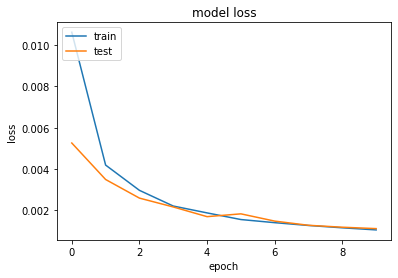

In [60]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('./graphics/model_loss.png')
plt.show()

## Function to Check Reconstructed Photos

def show_image(x):
    plt.imshow(np.clip(x + 0.5, 0, 1))

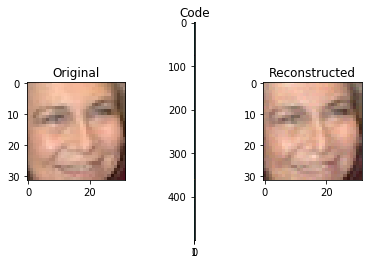

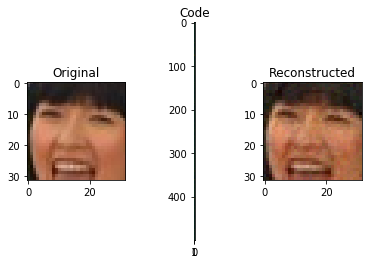

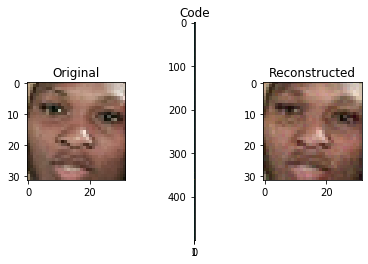

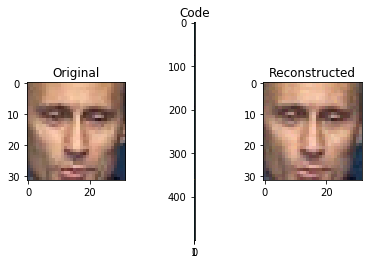

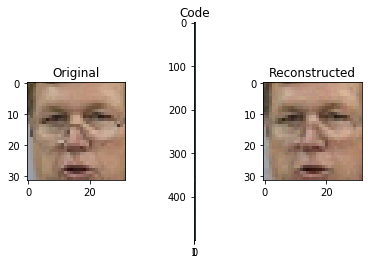

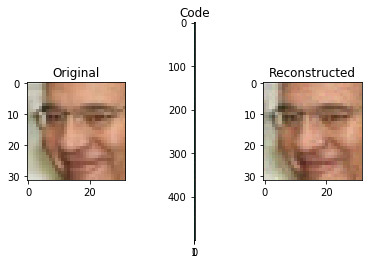

In [77]:
def visualize(img,encoder,decoder,file,counter):
    """Draws original, encoded and decoded images"""
    # img[None] will have shape of (1, 32, 32, 3) which is the same as the model input
    code = encoder.predict(img[None])[0]
    reco = decoder.predict(code[None])[0]

    plt.subplot(1,3,1)
    plt.title("Original")
    show_image(img)

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    show_image(reco)
    plt.savefig('./graphics/{}{}.png'.format(file, counter))
   
    plt.show()
counter = 0
for i in range(6):
    img = X_test[i]
    counter +=1
    visualize(img,encoder,decoder,"dataset", counter)

In [71]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

In [72]:
def load_dataset(path):
    img_data_list=[]
    data_path = path

    data_dir_list = os.listdir(data_path)
    for dataset in data_dir_list:
        img_list=os.listdir(data_path+'/'+ dataset)
        print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
        for img in img_list:
            input_img=cv2.imread(data_path + '/'+ dataset + '/'+ img )
            input_img=cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)
            #input_img_resize=cv2.resize(input_img,(64,64))
            faces = face_cascade.detectMultiScale(input_img, 1.1, 3)
            print (faces[0])
            input_img_resize=cv2.resize(input_img,(32,32))
            x,y,w,h = faces[0]
            print(x,y,w,h)
            face = input_img[y:y+h,x:x+w]
            face=cv2.resize(face,(32,32))
            #face = np.expand_dims(faces, axis=1)
            img_data_list.append(face)

    img_data = np.stack(img_data_list).astype('uint8')
    #img_data = img_data.astype('float32')
    return img_data

In [73]:
X = load_dataset("../data/fotop/")
X.shape

Loaded the images of dataset-Clara

[172  62 141 141]
172 62 141 141
Loaded the images of dataset-Cris

[862 816 191 191]
862 816 191 191
Loaded the images of dataset-Cesar

[216 220 247 247]
216 220 247 247
Loaded the images of dataset-Julio

[ 44  25 102 102]
44 25 102 102
Loaded the images of dataset-Alex

[137 152 299 299]
137 152 299 299


(5, 32, 32, 3)

In [74]:
X = X / 255.0 - 0.5

In [75]:
X.shape

(5, 32, 32, 3)

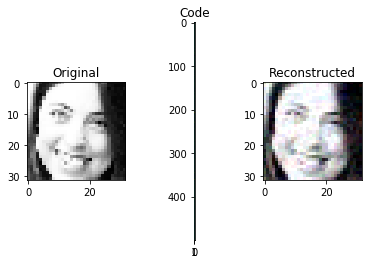

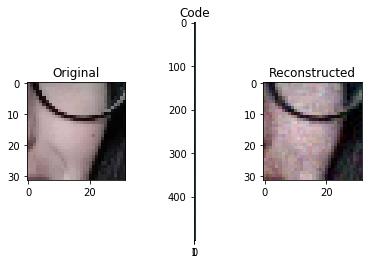

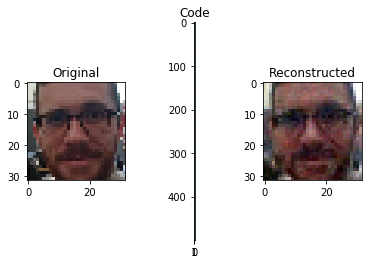

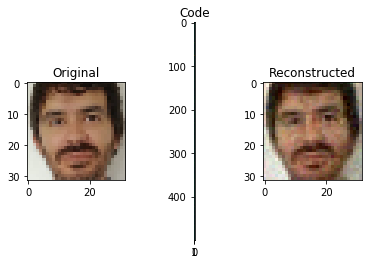

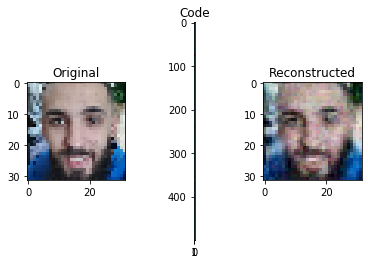

In [76]:

for i in range(5):
    img = X[i]
    visualize(img,encoder,decoder, "friendo")